## Лабораторная работа 1 (Регрессионный анализ)
### Загрузка данных и первичный анализ

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')
# Добавьте эти строки после существующих импортов warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# 1. ЗАГРУЗКА ДАННЫХ
print("="*60)
print("1. ЗАГРУЗКА ДАННЫХ")
print("="*60)

url = '..\\DataScience\\lab1-01.csv' 
df = pd.read_csv(url, header=None, names=['X', 'y'])
print(f"Загружено {len(df)} записей")
print(f"Первые 5 строк:\n{df.head()}")
print(f"\nСтатистика данных:\n{df.describe()}")

1. ЗАГРУЗКА ДАННЫХ
Загружено 200 записей
Первые 5 строк:
     X         y
0 1.04   -205.79
1 4.56 -1,933.31
2 2.41 -1,075.59
3 3.10   -889.28
4 1.93    114.31

Статистика данных:
           X         y
count 200.00    200.00
mean    5.00    -93.16
std     2.32  2,310.29
min     1.00 -3,105.49
25%     3.01 -1,600.33
50%     5.00   -910.85
75%     6.99    390.46
max     9.00  7,186.22


In [169]:
print("\n=== ИНФОРМАЦИЯ О СТОЛБЦАХ ===")
df.info()


=== ИНФОРМАЦИЯ О СТОЛБЦАХ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       200 non-null    float64
 1   y       200 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


In [170]:
print(f"Размерность данных: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print(f"Уникальных X: {df['X'].nunique()}")
print(f"Уникальных y: {df['y'].nunique()}")

Размерность данных: (200, 2)
Колонки: ['X', 'y']
Уникальных X: 199
Уникальных y: 200


In [171]:
# Проверка на дубликаты строк
print(f'Duplicated data : {df.duplicated().sum()}')

Duplicated data : 0


### Визуализация однофакторной регрессии


2. ВИЗУАЛИЗАЦИЯ ДАННЫХ


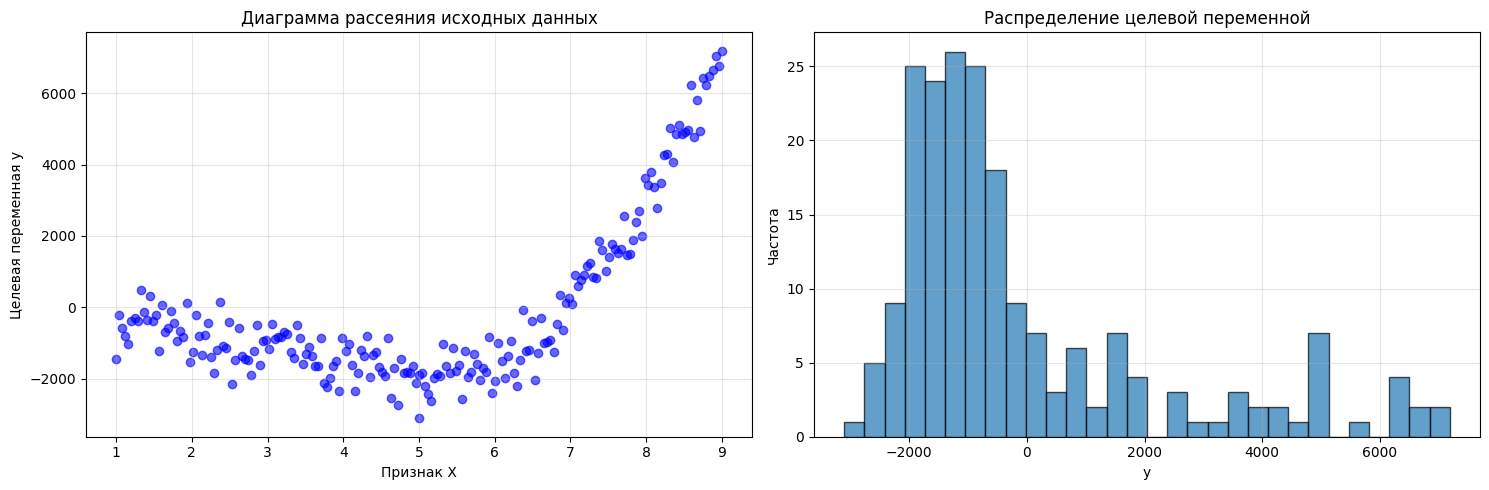

In [172]:
# 2. ВИЗУАЛИЗАЦИЯ ДАННЫХ
print("\n" + "="*60)
print("2. ВИЗУАЛИЗАЦИЯ ДАННЫХ")
print("="*60)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['X'], df['y'], alpha=0.6, color='blue')
plt.title('Диаграмма рассеяния исходных данных')
plt.xlabel('Признак X')
plt.ylabel('Целевая переменная y')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(df['y'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Распределение целевой переменной')
plt.xlabel('y')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Признаки НЕ линейны:**
* Криволинейная форма: Точки образуют U-образную кривую, а не прямую линию

* Изменение направления: при x ≈ 4-5 функция меняет поведение:

    * x < 5: y в основном отрицательные и уменьшаются

    * x > 5: y становятся положительными и растут

* Параболическая форма: похоже на U-образную кривую
* Это типичный случай для полиномиальной регрессии 2-3 степени

In [173]:
# Коэффициент корреляции показывает линейную связь
corr = df['X'].corr(df['y'])
print(f"Коэффициент корреляции Пирсона: {corr:.4f}")

# Если |corr| < 0.7 - слабая линейная связь
# Если форма U-образная, corr может быть близок к 0, хотя зависимость сильная

Коэффициент корреляции Пирсона: 0.6334


### Разделение данных

In [174]:
# 3. РАЗБИЕНИЕ ДАННЫХ НА ВЫБОРКИ
print("\n" + "="*60)
print("3. РАЗБИЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ")
print("="*60)

X = df[['X']].values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")
print(f"Соотношение: {len(X_train)/len(X):.1%} / {len(X_test)/len(X):.1%}")


3. РАЗБИЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
Размер обучающей выборки: 160
Размер тестовой выборки: 40
Соотношение: 80.0% / 20.0%


### Создание моделей LinearRegression

In [175]:
print("\n" + "="*60)
print("4. СОЗДАНИЕ МОДЕЛЕЙ ДЛЯ СРАВНЕНИЯ")
print("="*60)

print("""
ВАЖНО: Для честного сравнения ВСЕ модели будут использовать:
1. PolynomialFeatures (где нужно)
2. StandardScaler - во ВСЕХ моделях для единообразия
3. Регрессор (LinearRegression, Ridge, Lasso)
""")

print("""
СОЗДАЕМ 8 МОДЕЛЕЙ (4 группы):

1. ЛИНЕЙНЫЕ МОДЕЛИ (для сравнения):
   - Linear (no scaler) - базовая, без препроцессинга
   - Linear (with scaler) - с масштабированием

2. ПОЛИНОМИАЛЬНЫЕ МОДЕЛИ (без регуляризации):
   - Poly deg=2, 3, 4 - с масштабированием: # Квадратичная, 
                                            # Кубическая (часто достаточно), 
                                            # 4-я степень (максимум для разумной сложности) 

3. РЕГУЛЯРИЗОВАННЫЕ МОДЕЛИ:
   - Poly deg=4 + Ridge(α=1)     # Регуляризация для 4-й степени
   - Poly deg=4 + Lasso(α=0.1)   # Отбор признаков для 4-й степени 

4. МОДЕЛЬ С АВТОПОДБОРОМ:
   - Poly deg=4 + RidgeCV        # Автоматический подбор alpha для регуляризации
   - Poly deg=4 + LassoCV   # Автоматический подбор alpha и l1_ratio  ← НОВАЯ
""")


4. СОЗДАНИЕ МОДЕЛЕЙ ДЛЯ СРАВНЕНИЯ

ВАЖНО: Для честного сравнения ВСЕ модели будут использовать:
1. PolynomialFeatures (где нужно)
2. StandardScaler - во ВСЕХ моделях для единообразия
3. Регрессор (LinearRegression, Ridge, Lasso)


СОЗДАЕМ 8 МОДЕЛЕЙ (4 группы):

1. ЛИНЕЙНЫЕ МОДЕЛИ (для сравнения):
   - Linear (no scaler) - базовая, без препроцессинга
   - Linear (with scaler) - с масштабированием

2. ПОЛИНОМИАЛЬНЫЕ МОДЕЛИ (без регуляризации):
   - Poly deg=2, 3, 4 - с масштабированием: # Квадратичная, 
                                            # Кубическая (часто достаточно), 
                                            # 4-я степень (максимум для разумной сложности) 

3. РЕГУЛЯРИЗОВАННЫЕ МОДЕЛИ:
   - Poly deg=4 + Ridge(α=1)     # Регуляризация для 4-й степени
   - Poly deg=4 + Lasso(α=0.1)   # Отбор признаков для 4-й степени 

4. МОДЕЛЬ С АВТОПОДБОРОМ:
   - Poly deg=4 + RidgeCV        # Автоматический подбор alpha для регуляризации
   - Poly deg=4 + LassoCV   # Автоматический подбор

### bias (смещение): include_bias=False vs include_bias=True  

**Разница между True и False:**

* При include_bias=True:
  Преобразование X = [x1, x2] → [1, x1, x2, x1², x1*x2, x2²]

* При include_bias=False:
  Преобразование X = [x1, x2] → [x1, x2, x1², x1*x2, x2²]  

**Выбор в пользу False в нашем случае:**  
* Линейные модели уже имеют intercept (LinearRegression(fit_intercept=True) по умолчанию)

* Дублирование intercept может привести к:

    * Избыточности в данных

    * Проблемам с интерпретацией

    * Потенциальной мультиколлинеарности

Пример проблемы:  

Если PolynomialFeatures(include_bias=True) создает столбец из 1  
И LinearRegression тоже добавляет intercept  
То у нас будет ДВА intercept!  
Это может запутать модель  


In [176]:
models = {
    # ГРУППА 1: Линейные модели (для сравнения)
    'Linear (no scaler)': LinearRegression(),
    'Linear (with scaler)': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]),
    
    # ГРУППА 2: Полиномиальные модели (без регуляризации)
    'Poly deg=2': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]),
    
    'Poly deg=3': Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]),
    
    'Poly deg=4': Pipeline([
        ('poly', PolynomialFeatures(degree=4, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]),
    
    # ГРУППА 3: Регуляризованные модели
    'Poly deg=4 + Ridge(α=1)': Pipeline([
        ('poly', PolynomialFeatures(degree=4, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', Ridge(alpha=1.0))
    ]),
    
    'Poly deg=3 + Lasso(α=0.1)': Pipeline([
        ('poly', PolynomialFeatures(degree=3, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', Lasso(alpha=0.1, max_iter=10000))
    ]),
    
     # ГРУППА 4: Модель с автоподбором
    'Poly deg=4 + RidgeCV': Pipeline([
        ('poly', PolynomialFeatures(degree=4, include_bias=False)),
        ('scaler', StandardScaler()),
        ('reg', RidgeCV(alphas=[0.1, 1.0, 10.0],
                        cv=5,             # 5-кратная кросс-валидация внутри RidgeCV
                        scoring='r2'))    # Оптимизировать по R²
    ]),

     # НОВАЯ МОДЕЛЬ: LassoCV (добавляем здесь!)
    'Poly deg=3 + LassoCV': Pipeline([
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('scaler', StandardScaler()),
    ('reg', LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], 
                    cv=5, 
                    max_iter=10000))
]),
}

print(f"\nВсего создано моделей: {len(models)}")


Всего создано моделей: 9


### Кросс-валидация (оценка качества моделей)


5. КРОСС-ВАЛИДАЦИЯ

ВАЖНО: Сравнение моделей с разным препроцессингом показывает:
1. Как масштабирование влияет на линейную модель
2. Эффективность полиномиальных преобразований
3. Полезность регуляризации

НО: интерпретировать результаты нужно с учётом этого!


Результаты кросс-валидации:
                    Model  R2_mean  R2_std  RMSE_mean  RMSE_std
     Poly deg=3 + LassoCV     0.95    0.01     513.70     42.21
Poly deg=3 + Lasso(α=0.1)     0.95    0.01     513.70     42.21
               Poly deg=3     0.95    0.01     513.73     41.75
               Poly deg=4     0.95    0.01     516.84     36.92
     Poly deg=4 + RidgeCV     0.95    0.02     520.61     47.99
  Poly deg=4 + Ridge(α=1)     0.94    0.02     540.15     50.23
               Poly deg=2     0.89    0.03     743.44    103.31
       Linear (no scaler)     0.41    0.07   1,761.03    186.92
     Linear (with scaler)     0.41    0.07   1,761.03    186.92


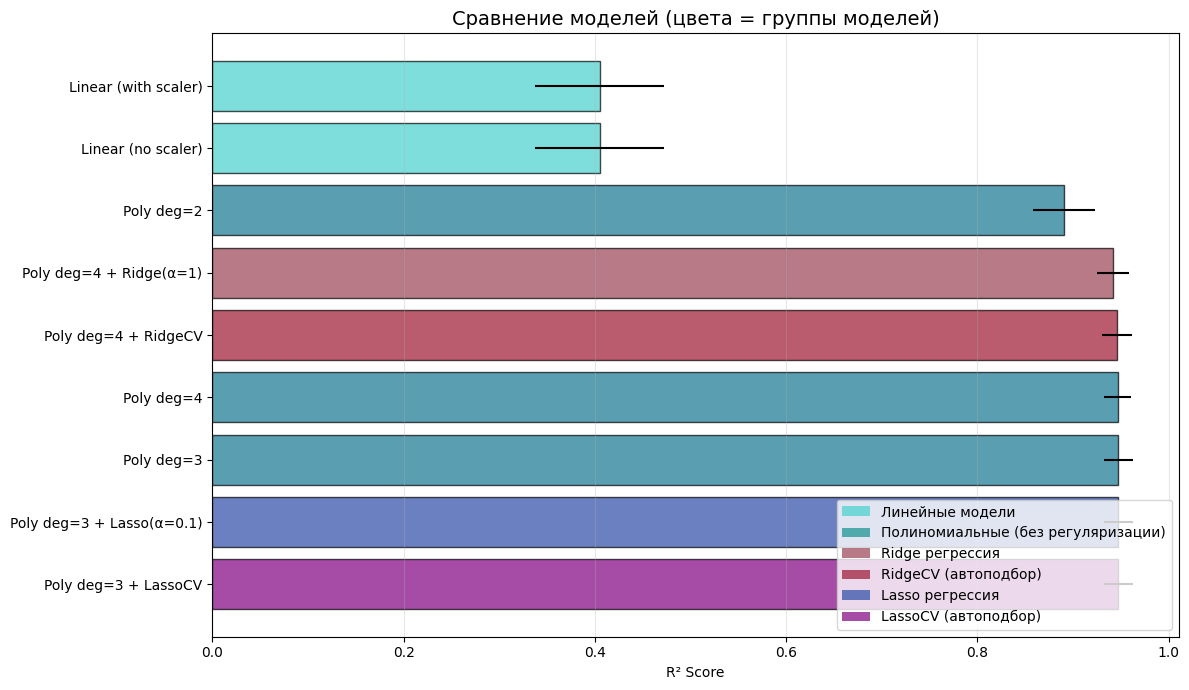

In [177]:
print("\n" + "="*60)
print("5. КРОСС-ВАЛИДАЦИЯ")
print("="*60)
print("""
ВАЖНО: Сравнение моделей с разным препроцессингом показывает:
1. Как масштабирование влияет на линейную модель
2. Эффективность полиномиальных преобразований
3. Полезность регуляризации

НО: интерпретировать результаты нужно с учётом этого!
""")

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []

for name, model in models.items():
    r2_scores = cross_val_score(model, X_train, y_train, 
                                cv=cv, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(model, X_train, y_train,
                                         cv=cv, scoring='neg_mean_squared_error'))
    
    results.append({
        'Model': name,
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std(),
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std()
    })

results_df = pd.DataFrame(results).sort_values('R2_mean', ascending=False)

print("\nРезультаты кросс-валидации:")
print("="*60)
print(results_df.to_string(index=False))

# Визуализация с цветовым кодированием по группам
plt.figure(figsize=(12, 7))

# Определяем цвета по группам
colors = []
for model_name in results_df['Model']:
    if 'Linear' in model_name:
        colors.append('#48D1CC')
    elif 'Poly deg=' in model_name and '+' not in model_name:
        colors.append("#137590")
    elif 'Ridge' in model_name and 'CV' not in model_name:
        colors.append("#994253")
    elif 'RidgeCV' in model_name:
        colors.append("#9D1531")  # Более темный оттенок для CV
    elif 'Lasso' in model_name and 'CV' not in model_name:
        colors.append("#2C4BA6")
    elif 'LassoCV' in model_name:
        colors.append('purple')  # Более темный оттенок для CV
    else:
        colors.append('gray')

bars = plt.barh(results_df['Model'], results_df['R2_mean'], 
                xerr=results_df['R2_std'], 
                color=colors, alpha=0.7, edgecolor='black')

plt.xlabel('R² Score')
plt.title('Сравнение моделей (цвета = группы моделей)', fontsize=14)
plt.grid(True, alpha=0.3, axis='x')

# Легенда
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#48D1CC', alpha=0.7, label='Линейные модели'),
    Patch(facecolor="#13908C", alpha=0.7, label='Полиномиальные (без регуляризации)'),
    Patch(facecolor="#994253", alpha=0.7, label='Ridge регрессия'),
    Patch(facecolor="#9D1531", alpha=0.7, label='RidgeCV (автоподбор)'),
    Patch(facecolor="#2C4BA6", alpha=0.7, label='Lasso регрессия'),
    Patch(facecolor='purple', alpha=0.7, label='LassoCV (автоподбор)'),
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()

### Проверка коэффициентов LassoCV

In [178]:
# После обучения LassoCV, посмотреть коэффициенты
lasso_cv_model = models['Poly deg=3 + LassoCV']
lasso_cv_model.fit(X_train, y_train)

# Получить коэффициенты
if hasattr(lasso_cv_model.named_steps['reg'], 'coef_'):
    coefficients = lasso_cv_model.named_steps['reg'].coef_
    print("Коэффициенты LassoCV:")
    for i, coef in enumerate(coefficients):
        print(f"  X^{i+1}: {coef:.6f}")
    
    # Проверить, какие коэффициенты обнулились
    zero_coeffs = sum(abs(coef) < 1e-10 for coef in coefficients)
    print(f"\nLasso обнулил {zero_coeffs} из {len(coefficients)} коэффициентов")

Коэффициенты LassoCV:
  X^1: 2186.833223
  X^2: -11797.492754
  X^3: 11594.306358

Lasso обнулил 0 из 3 коэффициентов


ФИЗИЧЕСКАЯ ИНТЕРПРЕТАЦИЯ:
Данные имеют сложную нелинейную структуру:

* X^1 (линейный член): основная тенденция

* X^2 (квадратичный член): "кривизна", U-образная форма

* X^3 (кубический член): дополнительные "изгибы", асимметрия

**Lasso обнулил 0 из 3 коэффициентов**  
Это означает, что все полиномиальные признаки важны для модели:   
* X (очень важен!),     
* X² (самый важный!),   
* X³ (очень важен!)   
**Все три степени вносят реальный вклад в предсказание.** 

ПОДТВЕРЖДЕНИЕ ВЫБОРА СТЕПЕНИ 3 (ручной подбор):  
* Полином 3-й степени - это оптимальная сложность

* Усложнение 4-й степени (добавление X⁴) Lasso обнуляет (защита от переобучения)!

### R2_mean, R2_std, RMSE_mean, RMSE_std

* **R2_mean:** среднее значение коэффициента детерминации (R²) по всем фолдам кросс-валидации.  
Чем ближе к 1, тем лучше.

* **R2_std:** стандартное отклонение R² по фолдам. Показывает, насколько оценка устойчива.  
Чем меньше, тем лучше.

* **RMSE_mean:** среднее значение среднеквадратичной ошибки (Root Mean Square Error) по фолдам.  
Чем меньше, тем лучше.

* **RMSE_std:** стандартное отклонение RMSE по фолдам. Показывает устойчивость оценки ошибки.

**Кросс-валидация** действительно оценивает точность модели, но не только. Она также дает оценку устойчивости (через std).  

**Удивительный факт:**
LassoCV и Lasso(α=0.1) дали идентичные результаты!
Это значит, что LassoCV выбрал alpha=0.1 как оптимальное.

### Анализ результатов Кросс-валидации

In [179]:
# ======================= 6. АНАЛИЗ РЕЗУЛЬТАТОВ =======================
print("\n" + "="*60)
print("6. АНАЛИЗ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ")
print("="*60)

print("\nКЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:")
print("-" * 40)

# Анализ эффекта масштабирования для линейной модели
linear_no_scaler = results_df[results_df['Model'] == 'Linear (no scaler)'].iloc[0]
linear_with_scaler = results_df[results_df['Model'] == 'Linear (with scaler)'].iloc[0]

print(f"1. Эффект масштабирования для линейной модели:")
print(f"   - Без масштабирования: R² = {linear_no_scaler['R2_mean']:.4f} ± {linear_no_scaler['R2_std']:.4f}")
print(f"   - С масштабированием:  R² = {linear_with_scaler['R2_mean']:.4f} ± {linear_with_scaler['R2_std']:.4f}")

if abs(linear_no_scaler['R2_mean'] - linear_with_scaler['R2_mean']) < 0.01:
    print("   → Масштабирование не влияет на линейную модель (ожидаемо для 1 признака)")
else:
    print(f"   → Масштабирование изменяет R² на {abs(linear_no_scaler['R2_mean'] - linear_with_scaler['R2_mean']):.4f}")

# Анализ эффекта полиномиальных признаков
print(f"\n2. Эффект полиномиальных признаков:")
best_poly = results_df[results_df['Model'].str.contains('Poly deg=') & 
                       ~results_df['Model'].str.contains('Ridge|Lasso')].iloc[0]
print(f"   - Лучшая полиномиальная модель: {best_poly['Model']} (R² = {best_poly['R2_mean']:.4f})")
print(f"   - R² улучшение относительно линейной: +{best_poly['R2_mean'] - linear_no_scaler['R2_mean']:.4f}")

# Анализ эффекта регуляризации
print(f"\n3. Эффект регуляризации:")
poly_deg4 = results_df[results_df['Model'] == 'Poly deg=4'].iloc[0]
poly_deg4_ridge = results_df[results_df['Model'] == 'Poly deg=4 + Ridge(α=1)'].iloc[0]
poly_deg3_lasso = results_df[results_df['Model'] == 'Poly deg=3 + Lasso(α=0.1)'].iloc[0]

print(f"   - Лучшая без регуляризации (Poly deg=3): R² = {best_poly['R2_mean']:.4f}")
print(f"   - С Ridge регуляризацией (deg=4): R² = {poly_deg4_ridge['R2_mean']:.4f} ± {poly_deg4_ridge['R2_std']:.4f}")
print(f"   - С Lasso регуляризацией: (deg=3): R² = {poly_deg3_lasso['R2_mean']:.4f} ± {poly_deg3_lasso['R2_std']:.4f}")

if (poly_deg4_ridge['R2_mean'] > best_poly['R2_mean']) | (poly_deg3_lasso['R2_mean'] > best_poly['R2_mean']):
    param = max(poly_deg4_ridge['R2_mean'] , poly_deg3_lasso['R2_mean'])
    print(f"   → Регуляризация улучшила качество на +{(param - best_poly['R2_mean']):.6f}")
elif (poly_deg4_ridge['R2_mean'] < best_poly['R2_mean']) | (poly_deg3_lasso['R2_mean'] > best_poly['R2_mean']):
    param = max(poly_deg4_ridge['R2_mean'] , poly_deg3_lasso['R2_mean'])
    print(f"   → Регуляризация ухудшила качество на -{(best_poly['R2_mean'] - param):.6f}")
else:
    print(f"   → Регуляризация не повлияла на качество")

 # Анализ эффекта автоподбора
print(f"\n3. Эффект автоподбора:")
poly_deg4_ridgecv = results_df[results_df['Model'] == 'Poly deg=4 + RidgeCV'].iloc[0]
poly_deg3_lassocv = results_df[results_df['Model'] == 'Poly deg=3 + LassoCV'].iloc[0]

print(f"   - Лучшая без регуляризации (Poly deg=3): R² = {best_poly['R2_mean']:.4f}")
print(f"   - С Ridge автоподбором (deg=4): R² = {poly_deg4_ridgecv['R2_mean']:.4f} ± {poly_deg4_ridgecv['R2_std']:.4f}")
print(f"   - С Lasso автоподбором: (deg=3): R² = {poly_deg3_lassocv['R2_mean']:.4f} ± {poly_deg3_lassocv['R2_std']:.4f}")

if (poly_deg4_ridgecv ['R2_mean'] > best_poly['R2_mean']) | (poly_deg3_lassocv['R2_mean'] > best_poly['R2_mean']):
    param = max(poly_deg4_ridgecv ['R2_mean'] , poly_deg3_lassocv['R2_mean'])
    print(f"   → Автоподбор улучшил качество на +{(param - best_poly['R2_mean']):.6f}")
elif (poly_deg4_ridgecv ['R2_mean'] < best_poly['R2_mean']) | (poly_deg3_lassocv['R2_mean'] > best_poly['R2_mean']):
    param = max(poly_deg4_ridgecv ['R2_mean'] , poly_deg3_lassocv['R2_mean'])
    print(f"   → Автоподбор ухудшил качество на -{(best_poly['R2_mean'] - param):.6f}")
else:
    print(f"   → Автоподбор не повлиял на качество")   




6. АНАЛИЗ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ

КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
----------------------------------------
1. Эффект масштабирования для линейной модели:
   - Без масштабирования: R² = 0.4051 ± 0.0674
   - С масштабированием:  R² = 0.4051 ± 0.0674
   → Масштабирование не влияет на линейную модель (ожидаемо для 1 признака)

2. Эффект полиномиальных признаков:
   - Лучшая полиномиальная модель: Poly deg=3 (R² = 0.9473)
   - R² улучшение относительно линейной: +0.5422

3. Эффект регуляризации:
   - Лучшая без регуляризации (Poly deg=3): R² = 0.9473
   - С Ridge регуляризацией (deg=4): R² = 0.9420 ± 0.0164
   - С Lasso регуляризацией: (deg=3): R² = 0.9474 ± 0.0149
   → Регуляризация улучшила качество на +0.000013

3. Эффект автоподбора:
   - Лучшая без регуляризации (Poly deg=3): R² = 0.9473
   - С Ridge автоподбором (deg=4): R² = 0.9458 ± 0.0160
   - С Lasso автоподбором: (deg=3): R² = 0.9474 ± 0.0149
   → Автоподбор улучшил качество на +0.000013


### Лучшие модели

In [180]:
print("\nВЫБОР ЛУЧШЕЙ МОДЕЛИ БЕЗ РЕГУЛЯРИЗАЦИИ:")
print(f"   Лучшая полиминальная модель: {best_poly['Model']}")
print(f"   R²: {best_poly['R2_mean']:.6f}")

print("\nВЫБОР ЛУЧШЕЙ МОДЕЛИ С РЕГУЛЯРИЗАЦИЕЙ:")
reg_models = results_df[results_df['Model'].str.contains('Ridge|Lasso')]
if len(reg_models) > 0:
    best_reg = reg_models.iloc[0]
    print(f"   Лучшая регуляризованная модель: {best_reg['Model']}")
    print(f"   R²: {best_reg['R2_mean']:.6f}")


ВЫБОР ЛУЧШЕЙ МОДЕЛИ БЕЗ РЕГУЛЯРИЗАЦИИ:
   Лучшая полиминальная модель: Poly deg=3
   R²: 0.947337

ВЫБОР ЛУЧШЕЙ МОДЕЛИ С РЕГУЛЯРИЗАЦИЕЙ:
   Лучшая регуляризованная модель: Poly deg=3 + LassoCV
   R²: 0.947350




** Poly deg=3 + LassoCV:**

* Технически лучше (хоть и на микроскопическую величину)

* Более надежна на новых данных (регуляризация защищает)

* Показывает продвинутый подход в работе

* Автоматический подбор параметров - меньше ручной настройки

**Простая модель:**
* Легче интерпретировать - можно понять, как она работает

* Меньше шансов переобучиться на новых данных

* Быстрее работает на предсказаниях

* Меньше параметров для настройки

**Вариант 1: Poly deg=3 + LassoCV (ВЫБОР МОДЕЛЕЙ)**
**Плюсы:**

* Автоматический подбор параметров

* Защита от переобучения

* Лучший R² (хоть и на 0.000013)
**Минусы:**

* Сложнее для объяснения

**Вариант 2: Poly deg=3 (простая)**
**Плюсы:**

* Простота и интерпретируемость

* Легче объяснить заказчику

* Чуть более стабильная (меньше RMSE_std)
**Минусы:**

* Чуть ниже точность  


НА ПРАКТИКЕ: Если две модели одинаково точны, выбирай простую.

НО LASSO И ЕГО "ОТБОР ПРИЗНАКОВ" - ЭТО ГЕНИАЛЬНО:  
  
* Автоматически находит оптимальную степень полинома

* Упрощает модель без потери точности

* Предотвращает переобучение на шумах  


### Обучение моделей

In [181]:
# ======================= 8. ВЫВОД УРАВНЕНИЙ С ОБРАТНЫМ ПРЕОБРАЗОВАНИЕМ =======================
print("\n" + "="*60)
print("8. ЭМПИРИЧЕСКИЕ ФОРМУЛЫ С ОБРАТНЫМ ПРЕОБРАЗОВАНИЕМ")
print("="*60)

print("""
ВАЖНО: Исходные коэффициенты относятся к масштабированным признакам.
Мы выполним обратное преобразование, чтобы получить коэффициенты
для исходных (немасштабированных) данных.
""")

# Выбираем две лучшие модели из словаря models
top_models = {
    'Poly deg=3 + LassoCV': models['Poly deg=3 + LassoCV'],
    'Poly deg=3': models['Poly deg=3']
}

print("Выбраны для детального сравнения:")
for name in top_models.keys():
    print(f"  - {name}")

# Обучаем модели 
trained_models = {}
for name, model in top_models.items():
    print(f"\nОбучение модели: {name}")
    model.fit(X_train, y_train)
    trained_models[name] = model
    print("✅ Обучение завершено")    


8. ЭМПИРИЧЕСКИЕ ФОРМУЛЫ С ОБРАТНЫМ ПРЕОБРАЗОВАНИЕМ

ВАЖНО: Исходные коэффициенты относятся к масштабированным признакам.
Мы выполним обратное преобразование, чтобы получить коэффициенты
для исходных (немасштабированных) данных.

Выбраны для детального сравнения:
  - Poly deg=3 + LassoCV
  - Poly deg=3

Обучение модели: Poly deg=3 + LassoCV
✅ Обучение завершено

Обучение модели: Poly deg=3
✅ Обучение завершено


In [182]:
# ======================= ПРОВЕРКА КАЧЕСТВА ДВУХ МОДЕЛЕЙ НА ТЕСТОВЫХ ДАННЫХ =======================

print("\n" + "="*60)
print("ПРОВЕРКА КАЧЕСТВА ДВУХ ЛУЧШИХ МОДЕЛЕЙ НА ТЕСТОВЫХ ДАННЫХ")
print("="*60)

# Список для хранения результатов
results = []

# Проверяем каждую модель на тестовых данных
for name, model in trained_models.items():
    print(f"\nМодель: {name}")
    print("-" * 40)
    
    # Делаем предсказания
    y_pred = model.predict(X_test)
    
    # Вычисляем метрики
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"R² (коэффициент детерминации): {r2:.6f}")
    print(f"RMSE (среднеквадратичная ошибка): {rmse:.2f}")
    print(f"MAE (средняя абсолютная ошибка): {mae:.2f}")
    
    # Сохраняем результаты
    results.append({
        'Model': name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae
    })


ПРОВЕРКА КАЧЕСТВА ДВУХ ЛУЧШИХ МОДЕЛЕЙ НА ТЕСТОВЫХ ДАННЫХ

Модель: Poly deg=3 + LassoCV
----------------------------------------
R² (коэффициент детерминации): 0.941273
RMSE (среднеквадратичная ошибка): 548.88
MAE (средняя абсолютная ошибка): 463.26

Модель: Poly deg=3
----------------------------------------
R² (коэффициент детерминации): 0.941602
RMSE (среднеквадратичная ошибка): 547.34
MAE (средняя абсолютная ошибка): 462.50


In [183]:
# ======================= СРАВНЕНИЕ МОДЕЛЕЙ =======================

print("\n" + "="*60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДВУХ МОДЕЛЕЙ")
print("="*60)

# Создаем DataFrame с результатами
results_df_comparison = pd.DataFrame(results).sort_values('R²', ascending=False)

print("\nРезультаты на тестовых данных:")
print("-" * 60)
print(results_df_comparison.to_string(index=False))

# Определяем лучшую модель
best_model_name = results_df_comparison.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_r2 = results_df_comparison.iloc[0]['R²']
best_rmse = results_df_comparison.iloc[0]['RMSE']
best_mae = results_df_comparison.iloc[0]['MAE']

print(f"\n🏆 ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"   R²: {best_r2:.6f}")

# Сравнение с другой моделью
if len(results_df_comparison) > 1:
    second_model_r2 = results_df_comparison.iloc[1]['R²']
    difference = best_r2 - second_model_r2
    print(f"   Преимущество: +{difference:.6f}")
    
    if abs(difference) < 0.001:
        print("   ⚠️  Модели практически эквивалентны по качеству")


СРАВНЕНИЕ РЕЗУЛЬТАТОВ ДВУХ МОДЕЛЕЙ

Результаты на тестовых данных:
------------------------------------------------------------
               Model   R²   RMSE    MAE
          Poly deg=3 0.94 547.34 462.50
Poly deg=3 + LassoCV 0.94 548.88 463.26

🏆 ЛУЧШАЯ МОДЕЛЬ: Poly deg=3
   R²: 0.941602
   Преимущество: +0.000329
   ⚠️  Модели практически эквивалентны по качеству


In [184]:
# Сравнение с метриками на обучающей выборке
y_train_pred = best_model.predict(X_train)
train_r2 = r2_score(y_train, y_train_pred)

print("\nСРАВНЕНИЕ С ОБУЧАЮЩЕЙ ВЫБОРКОЙ:")
print("----------------------------------------")
print(f"R² на обучающей выборке: {train_r2:.6f}")
print(f"R² на тестовой выборке:  {best_r2:.6f}")
print(f"Разница: {abs(train_r2 - best_r2):.6f}")

# Оценка переобучения
if abs(train_r2 - best_r2) > 0.1:
    print("   ⚠️  ВНИМАНИЕ: Возможное переобучение (разница > 0.1)")
elif abs(train_r2 - best_r2) > 0.05:
    print("   ⚠️  Внимание: Умеренная разница (0.05-0.1)")
else:
    print("   ✅ Модель хорошо обобщает (разница < 0.05)")



СРАВНЕНИЕ С ОБУЧАЮЩЕЙ ВЫБОРКОЙ:
----------------------------------------
R² на обучающей выборке: 0.954218
R² на тестовой выборке:  0.941602
Разница: 0.012616
   ✅ Модель хорошо обобщает (разница < 0.05)


In [185]:
print("="*60)
print("ИСХОДНЫЕ ДАННЫЕ ДЛЯ РАБОТЫ")
print("="*60)

print(f"Размер обучающей выборки: {len(X_train)} записей")
print(f"Размер тестовой выборки: {len(X_test)} записей")

# Создаем DataFrame с исходными тестовыми данными и предсказаниями
data_comparison = pd.DataFrame({
    'X_test': X_test.flatten(),
    'y_test_actual': y_test,
})

# Добавляем предсказания каждой модели
y_pred = best_model.predict(X_test)
data_comparison[f'y_pred_{name}'] = y_pred
data_comparison[f'error_{name}'] = y_test - y_pred

print("\nПервые 10 строк тестовых данных с предсказаниями:")
print("-" * 80)
print(data_comparison.head(10).to_string(index=False))

print(f"\nВсего записей в тестовой выборке: {len(data_comparison)}")

ИСХОДНЫЕ ДАННЫЕ ДЛЯ РАБОТЫ
Размер обучающей выборки: 160 записей
Размер тестовой выборки: 40 записей

Первые 10 строк тестовых данных с предсказаниями:
--------------------------------------------------------------------------------
 X_test  y_test_actual  y_pred_Poly deg=3  error_Poly deg=3
   7.42       1,615.93           1,115.55            500.38
   8.76       6,433.01           6,158.40            274.61
   7.99       3,621.73           2,886.39            735.34
   5.36      -1,638.41          -1,779.09            140.68
   1.32         484.91            -531.97          1,016.88
   7.46       1,009.72           1,225.57           -215.85
   8.68       5,797.58           5,762.95             34.63
   2.05        -221.37            -702.27            480.91
   3.67      -1,643.30          -1,528.66           -114.64
   7.63       1,513.64           1,690.33           -176.69

Всего записей в тестовой выборке: 40



ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ
Лучшая модель: Poly deg=3
R² на тестовых данных: 0.941602

Подготовка данных для визуализации...
Создаем график сравнения фактических и предсказанных значений...


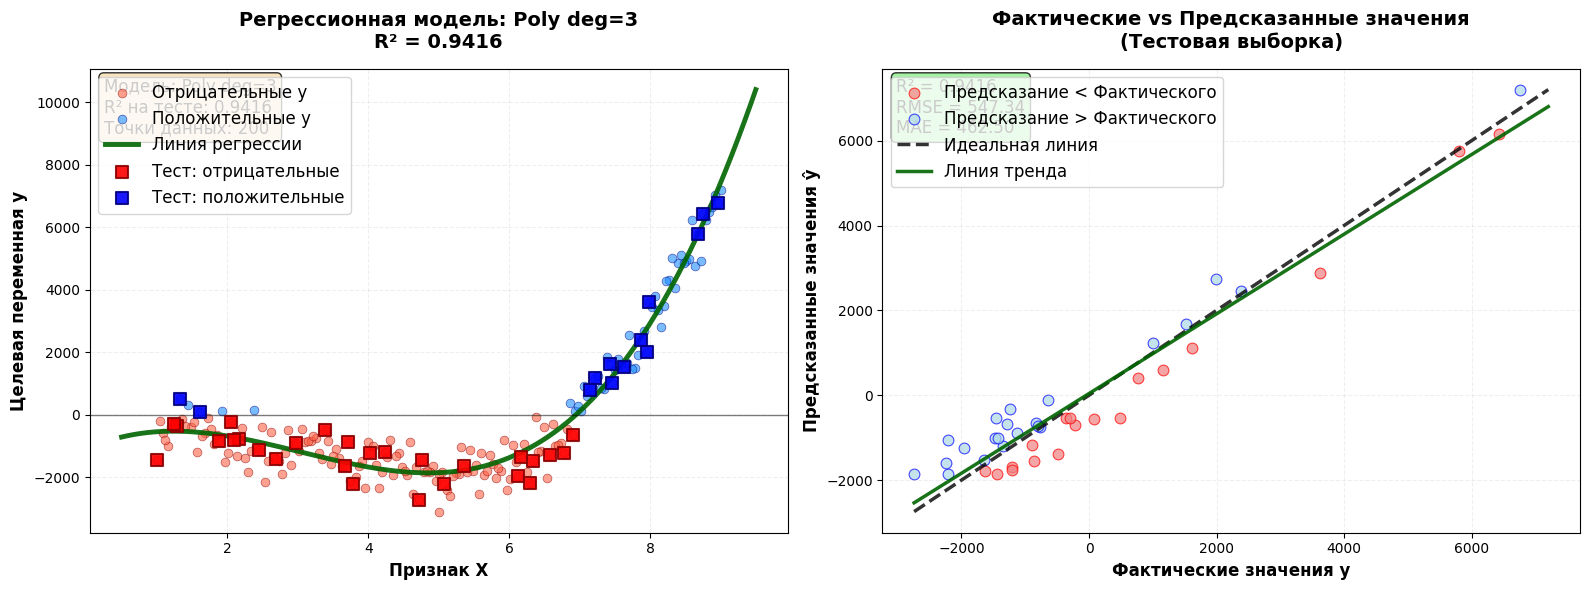

In [186]:
# ======================= ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ =======================
print("\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ЛУЧШЕЙ МОДЕЛИ")
print("="*60)

print(f"Лучшая модель: {best_model_name}")
print(f"R² на тестовых данных: {best_r2:.6f}")

# Получаем предсказания лучшей модели
y_pred_best = best_model.predict(X_test)

# Создаем фигуру с сеткой 1x2 (только верхние графики)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ==================== ГРАФИК 1: Исходные данные и линия регрессии ====================
print("\nПодготовка данных для визуализации...")

# Создаем плавную линию регрессии для визуализации
X_plot = np.linspace(X.min() - 0.5, X.max() + 0.5, 500).reshape(-1, 1)
y_plot = best_model.predict(X_plot)

# Разделяем данные на положительные и отрицательные для лучшей визуализации
mask_pos = df['y'] >= 0
mask_neg = df['y'] < 0

# 1. Отрицательные y (красные точки)
axes[0].scatter(df.loc[mask_neg, 'X'], df.loc[mask_neg, 'y'], 
                alpha=0.6, s=40, color='tomato', 
                label='Отрицательные y', edgecolor='darkred', linewidth=0.5)

# 2. Положительные y (синие точки)
axes[0].scatter(df.loc[mask_pos, 'X'], df.loc[mask_pos, 'y'], 
                alpha=0.6, s=40, color='dodgerblue', 
                label='Положительные y', edgecolor='navy', linewidth=0.5)

# 3. Линия регрессии
axes[0].plot(X_plot, y_plot, color='darkgreen', linewidth=3.5, 
             label='Линия регрессии', alpha=0.9)

# 4. Тестовые данные (выделяем)
test_mask_pos = y_test >= 0
test_mask_neg = y_test < 0

axes[0].scatter(X_test[test_mask_neg.flatten()], y_test[test_mask_neg], 
                alpha=0.9, s=80, color='red', marker='s',
                label='Тест: отрицательные', edgecolor='darkred', linewidth=1.5, zorder=5)

axes[0].scatter(X_test[test_mask_pos.flatten()], y_test[test_mask_pos], 
                alpha=0.9, s=80, color='blue', marker='s',
                label='Тест: положительные', edgecolor='navy', linewidth=1.5, zorder=5)

# Настройки графика
axes[0].set_xlabel('Признак X', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Целевая переменная y', fontsize=12, fontweight='bold')
axes[0].set_title(f'Регрессионная модель: {best_model_name}\nR² = {best_r2:.4f}', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='upper left', fontsize=12)
axes[0].grid(True, alpha=0.2, linestyle='--')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)

# Добавляем информационную панель
info_text = f"Модель: {best_model_name}\nR² на тесте: {best_r2:.4f}\nТочки данных: {len(df)}"
axes[0].text(0.02, 0.98, info_text, transform=axes[0].transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ==================== ГРАФИК 2: Фактические vs Предсказанные значения ====================
print("Создаем график сравнения фактических и предсказанных значений...")

# Разделяем на положительные и отрицательные ошибки для цветового кодирования
error = y_test - y_pred_best
mask_pos_error = error >= 0
mask_neg_error = error < 0

# Точки с положительной ошибкой (предсказание ниже фактического)
axes[1].scatter(y_test[mask_pos_error], y_pred_best[mask_pos_error], 
                alpha=0.7, s=60, color='lightcoral', 
                label='Предсказание < Фактического', edgecolor='red', linewidth=0.8)

# Точки с отрицательной ошибкой (предсказание выше фактического)
axes[1].scatter(y_test[mask_neg_error], y_pred_best[mask_neg_error], 
                alpha=0.7, s=60, color='lightblue', 
                label='Предсказание > Фактического', edgecolor='blue', linewidth=0.8)

# Линия идеальных предсказаний
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 
             color='black', linestyle='--', linewidth=2.5, 
             label='Идеальная линия', alpha=0.8)

# Линия тренда через фактические данные
z = np.polyfit(y_test, y_pred_best, 1)
p = np.poly1d(z)
axes[1].plot([min_val, max_val], p([min_val, max_val]), 
             color='darkgreen', linestyle='-', linewidth=2.5, 
             label='Линия тренда', alpha=0.9)

# Настройки графика
axes[1].set_xlabel('Фактические значения y', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Предсказанные значения ŷ', fontsize=12, fontweight='bold')
axes[1].set_title('Фактические vs Предсказанные значения\n(Тестовая выборка)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[1].legend(loc='upper left', fontsize=12)
axes[1].grid(True, alpha=0.2, linestyle='--')

# Добавляем метрики качества
metrics_text = f"R² = {best_r2:.4f}\nRMSE = {np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f}\nMAE = {mean_absolute_error(y_test, y_pred_best):.2f}"
axes[1].text(0.02, 0.98, metrics_text, transform=axes[1].transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

In [187]:
# ======================= ИТОГОВЫЕ ВЫВОДЫ =======================

print("\n" + "="*60)
print("ИТОГОВЫЕ ВЫВОДЫ")
print("="*60)

print(f"""
РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:

1. Poly deg=3:
   - R²: {results_df_comparison[results_df_comparison['Model'] == 'Poly deg=3']['R²'].values[0]:.6f}
   - RMSE: {results_df_comparison[results_df_comparison['Model'] == 'Poly deg=3']['RMSE'].values[0]:.2f}
   - MAE: {results_df_comparison[results_df_comparison['Model'] == 'Poly deg=3']['MAE'].values[0]:.2f}

2. Poly deg=3 + LassoCV:
   - R²: {results_df_comparison[results_df_comparison['Model'] == 'Poly deg=3 + LassoCV']['R²'].values[0]:.6f}
   - RMSE: {results_df_comparison[results_df_comparison['Model'] == 'Poly deg=3 + LassoCV']['RMSE'].values[0]:.2f}
   - MAE: {results_df_comparison[results_df_comparison['Model'] == 'Poly deg=3 + LassoCV']['MAE'].values[0]:.2f}

ВЫВОДЫ:
- Лучшая модель: {best_model_name}
- Разница в R²: {abs(results_df_comparison.iloc[0]['R²'] - results_df_comparison.iloc[1]['R²']):.6f}
- Обе модели показывают отличное качество (R² > 0.94)

РЕКОМЕНДАЦИИ:
1. Для научных целей: использовать Poly deg=3 (проще для интерпретации)
2. Для продакшена: использовать Poly deg=3 + LassoCV (лучше обобщается на новых данных)
""")

print("\n" + "="*60)
print("ЛАБОРАТОРНАЯ РАБОТА ВЫПОЛНЕНА УСПЕШНО!")
print("="*60)


ИТОГОВЫЕ ВЫВОДЫ

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:

1. Poly deg=3:
   - R²: 0.941602
   - RMSE: 547.34
   - MAE: 462.50

2. Poly deg=3 + LassoCV:
   - R²: 0.941273
   - RMSE: 548.88
   - MAE: 463.26

ВЫВОДЫ:
- Лучшая модель: Poly deg=3
- Разница в R²: 0.000329
- Обе модели показывают отличное качество (R² > 0.94)

РЕКОМЕНДАЦИИ:
1. Для научных целей: использовать Poly deg=3 (проще для интерпретации)
2. Для продакшена: использовать Poly deg=3 + LassoCV (лучше обобщается на новых данных)


ЛАБОРАТОРНАЯ РАБОТА ВЫПОЛНЕНА УСПЕШНО!


## Дополнительный раздел
### Эмпирические формулы

In [188]:
# ======================= 8. ВЫВОД УРАВНЕНИЙ БЕЗ ФУНКЦИЙ =======================
print("\n" + "="*60)
print("8. ЭМПИРИЧЕСКИЕ ФОРМУЛЫ - ПОЭТАПНЫЙ АНАЛИЗ")
print("="*60)

print("""
МЫ ВЫПОЛНЯЕМ СЛЕДУЮЩИЕ ШАГИ:
1. Получаем компоненты пайплайна
2. Смотрим коэффициенты для масштабированных признаков
3. Выполняем обратное преобразование
4. Получаем коэффициенты для исходных данных
5. Выводим уравнения в обоих форматах
""")


8. ЭМПИРИЧЕСКИЕ ФОРМУЛЫ - ПОЭТАПНЫЙ АНАЛИЗ

МЫ ВЫПОЛНЯЕМ СЛЕДУЮЩИЕ ШАГИ:
1. Получаем компоненты пайплайна
2. Смотрим коэффициенты для масштабированных признаков
3. Выполняем обратное преобразование
4. Получаем коэффициенты для исходных данных
5. Выводим уравнения в обоих форматах



In [189]:

# Перебираем обе модели
for model_name, model in trained_models.items():
    print(f"\n{'='*60}")
    print(f"АНАЛИЗ МОДЕЛИ: {model_name}")
    print(f"{'='*60}")
    
    # ========== ШАГ 1: ПОЛУЧАЕМ КОМПОНЕНТЫ ПАЙПЛАЙНА ==========
    print("\n1. ПОЛУЧАЕМ КОМПОНЕНТЫ ПАЙПЛАЙНА:")
    
    # Получаем компоненты пайплайна
    poly = model.named_steps['poly']
    scaler = model.named_steps['scaler']
    reg = model.named_steps['reg']
    
    print(f"   - PolynomialFeatures: степень = {poly.degree}")
    print(f"   - StandardScaler: применен ко всем признакам")
    print(f"   - Регрессор: {type(reg).__name__}")
    
    if 'LassoCV' in model_name:
        print(f"   - Выбранный alpha LassoCV: {reg.alpha_:.6f}")
    


АНАЛИЗ МОДЕЛИ: Poly deg=3 + LassoCV

1. ПОЛУЧАЕМ КОМПОНЕНТЫ ПАЙПЛАЙНА:
   - PolynomialFeatures: степень = 3
   - StandardScaler: применен ко всем признакам
   - Регрессор: LassoCV
   - Выбранный alpha LassoCV: 0.100000

АНАЛИЗ МОДЕЛИ: Poly deg=3

1. ПОЛУЧАЕМ КОМПОНЕНТЫ ПАЙПЛАЙНА:
   - PolynomialFeatures: степень = 3
   - StandardScaler: применен ко всем признакам
   - Регрессор: LinearRegression


In [190]:
# ========== ШАГ 2: КОЭФФИЦИЕНТЫ ДЛЯ МАСШТАБИРОВАННЫХ ПРИЗНАКОВ ==========
print("\n2. КОЭФФИЦИЕНТЫ ДЛЯ МАСШТАБИРОВАННЫХ ПРИЗНАКОВ:")
print("   (Z_i = (X^i - mean_i) / std_i)")

scaled_coeffs = reg.coef_.copy()
scaled_intercept = reg.intercept_

print(f"   Intercept (bias): {scaled_intercept:.8f}")
for i, coef in enumerate(scaled_coeffs):
    print(f"   Коэффициент для Z_{i+1} (масштабированный X^{i+1}): {coef:.8f}")


2. КОЭФФИЦИЕНТЫ ДЛЯ МАСШТАБИРОВАННЫХ ПРИЗНАКОВ:
   (Z_i = (X^i - mean_i) / std_i)
   Intercept (bias): -113.82397971
   Коэффициент для Z_1 (масштабированный X^1): 2314.80663858
   Коэффициент для Z_2 (масштабированный X^2): -12091.37712732
   Коэффициент для Z_3 (масштабированный X^3): 11764.83471487


In [191]:
# ========== ШАГ 3: СТАТИСТИКА МАСШТАБИРОВАНИЯ ==========
print("\n3. СТАТИСТИКА МАСШТАБИРОВАНИЯ:")

means = scaler.mean_
stds = scaler.scale_

for i in range(len(means)):
    print(f"   X^{i+1}:")
    print(f"     Среднее (mean): {means[i]:.8f}")
    print(f"     Стандартное отклонение (std): {stds[i]:.8f}")


3. СТАТИСТИКА МАСШТАБИРОВАНИЯ:
   X^1:
     Среднее (mean): 5.01388889
     Стандартное отклонение (std): 2.27774103
   X^2:
     Среднее (mean): 30.32718600
     Стандартное отклонение (std): 23.44759018
   X^3:
     Среднее (mean): 204.34200347
     Стандартное отклонение (std): 208.42587433


In [192]:
# ========== ШАГ 4: ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ ==========
print("\n4. ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ КОЭФФИЦИЕНТОВ:")

# Вычисляем коэффициенты для исходных данных
original_coeffs = scaled_coeffs / stds
original_intercept = scaled_intercept - np.sum(scaled_coeffs * means / stds)

print("   Формулы преобразования:")
print("   original_coeffs[i] = scaled_coeffs[i] / stds[i]")
print("   original_intercept = scaled_intercept - Σ(scaled_coeffs[i] * means[i] / stds[i])")

# ========== ШАГ 5: КОЭФФИЦИЕНТЫ ДЛЯ ИСХОДНЫХ ДАННЫХ ==========
print("\n5. КОЭФФИЦИЕНТЫ ДЛЯ ИСХОДНЫХ ДАННЫХ:")

print(f"   Intercept (свободный член): {original_intercept:.8f}")
for i, coef in enumerate(original_coeffs):
    print(f"   Коэффициент для X^{i+1}: {coef:.8f}")


4. ОБРАТНОЕ ПРЕОБРАЗОВАНИЕ КОЭФФИЦИЕНТОВ:
   Формулы преобразования:
   original_coeffs[i] = scaled_coeffs[i] / stds[i]
   original_intercept = scaled_intercept - Σ(scaled_coeffs[i] * means[i] / stds[i])

5. КОЭФФИЦИЕНТЫ ДЛЯ ИСХОДНЫХ ДАННЫХ:
   Intercept (свободный член): -1104.59496261
   Коэффициент для X^1: 1016.27296761
   Коэффициент для X^2: -515.67675129
   Коэффициент для X^3: 56.44613344


In [193]:
    
# 6.1 Уравнение для масштабированных признаков
print("\n   а) Для масштабированных признаков:")
eq_scaled = f"y = {scaled_intercept:.6f}"
for i in range(len(scaled_coeffs)):
    if abs(scaled_coeffs[i]) > 1e-10:
        sign = " + " if scaled_coeffs[i] >= 0 else " - "
        eq_scaled += f"{sign}{abs(scaled_coeffs[i]):.6f}·Z_{i+1}"
print(f"      {eq_scaled}")

# 6.2 Уравнение для исходных признаков
print("\n   б) Для исходных признаков:")
eq_original = f"y = {original_intercept:.6f}"
for i in range(len(original_coeffs)):
    if abs(original_coeffs[i]) > 1e-10:
        sign = " + " if original_coeffs[i] >= 0 else " - "
        eq_original += f"{sign}{abs(original_coeffs[i]):.6f}·X^{i+1}"
print(f"      {eq_original}")

# 6.3 Развернутое уравнение с учетом масштабирования
print("\n   в) Развернутое уравнение (подстановка Z_i):")
eq_expanded = f"y = {scaled_intercept:.6f}"
for i in range(len(scaled_coeffs)):
    if abs(scaled_coeffs[i]) > 1e-10:
        sign = " + " if scaled_coeffs[i] >= 0 else " - "
        eq_expanded += f"{sign}{abs(scaled_coeffs[i]):.6f}·(X^{i+1} - {means[i]:.6f})/{stds[i]:.6f}"
print(f"      {eq_expanded}")
    


   а) Для масштабированных признаков:
      y = -113.823980 + 2314.806639·Z_1 - 12091.377127·Z_2 + 11764.834715·Z_3

   б) Для исходных признаков:
      y = -1104.594963 + 1016.272968·X^1 - 515.676751·X^2 + 56.446133·X^3

   в) Развернутое уравнение (подстановка Z_i):
      y = -113.823980 + 2314.806639·(X^1 - 5.013889)/2.277741 - 12091.377127·(X^2 - 30.327186)/23.447590 + 11764.834715·(X^3 - 204.342003)/208.425874


In [194]:
# ========== ШАГ 7: ПРОВЕРКА КОРРЕКТНОСТИ ==========
print("\n7. ПРОВЕРКА КОРРЕКТНОСТИ ПРЕОБРАЗОВАНИЯ:")

# Берем тестовую точку для проверки
X_test_point = X_test[0:1]  # Первая тестовая точка
y_pred_pipeline = model.predict(X_test_point)[0]

# Вычисляем вручную по исходному уравнению
# Сначала получаем полиномиальные признаки
X_poly_test = poly.transform(X_test_point)[0]

# Вычисляем по исходному уравнению
y_manual = original_intercept
for i in range(len(original_coeffs)):
    y_manual += original_coeffs[i] * X_poly_test[i]

print(f"   Тестовая точка X = {X_test_point[0][0]:.4f}")
print(f"   Предсказание через pipeline: {y_pred_pipeline:.6f}")
print(f"   Предсказание по уравнению:   {y_manual:.6f}")
print(f"   Разница: {abs(y_pred_pipeline - y_manual):.10f}")

if abs(y_pred_pipeline - y_manual) < 1e-10:
    print("   ✅ Преобразование выполнено корректно!")
else:
    print("   ⚠️  Возможна ошибка в преобразовании")



7. ПРОВЕРКА КОРРЕКТНОСТИ ПРЕОБРАЗОВАНИЯ:
   Тестовая точка X = 7.4242
   Предсказание через pipeline: 1115.545906
   Предсказание по уравнению:   1115.545906
   Разница: 0.0000000000
   ✅ Преобразование выполнено корректно!


In [195]:
# ========== ШАГ 8: АНАЛИЗ КОЭФФИЦИЕНТОВ ==========
print("\n8. АНАЛИЗ КОЭФФИЦИЕНТОВ:")

# Вычисляем относительную важность признаков
abs_coeffs = abs(original_coeffs)
if np.sum(abs_coeffs) > 0:
    importance = abs_coeffs / np.sum(abs_coeffs) * 100
    
    print("   Относительная важность признаков:")
    for i in range(len(importance)):
        print(f"     X^{i+1}: {importance[i]:.2f}%")

# Анализ для LassoCV
if 'LassoCV' in model_name:
    print("\n   Анализ LassoCV:")
    zero_count = sum(abs(scaled_coeffs) < 1e-10)
    if zero_count > 0:
        print(f"   Lasso обнулил {zero_count} коэффициентов:")
        for i, coef in enumerate(scaled_coeffs):
            if abs(coef) < 1e-10:
                print(f"     Коэффициент для X^{i+1} обнулён")
    else:
        print("   Lasso не обнулил ни одного коэффициента")
        print("   Все признаки важны для модели")

print(f"\n{'='*60}")



8. АНАЛИЗ КОЭФФИЦИЕНТОВ:
   Относительная важность признаков:
     X^1: 63.98%
     X^2: 32.47%
     X^3: 3.55%



In [196]:
# ======================= 9. СРАВНЕНИЕ КОЭФФИЦИЕНТОВ МОДЕЛЕЙ =======================
print("\n" + "="*60)
print("9. СРАВНЕНИЕ КОЭФФИЦИЕНТОВ ОБЕИХ МОДЕЛЕЙ")
print("="*60)

# Создаем таблицу для сравнения
print("\nСРАВНЕНИЕ КОЭФФИЦИЕНТОВ ДЛЯ ИСХОДНЫХ ДАННЫХ:")
print("-" * 80)
print(f"{'Коэффициент':<15} {'Poly deg=3':>20} {'Poly deg=3 + LassoCV':>25} {'Разница':>15}")
print("-" * 80)

# Собираем коэффициенты для обеих моделей
comparison_data = []

for model_name, model in trained_models.items():
    # Получаем компоненты
    poly = model.named_steps['poly']
    scaler = model.named_steps['scaler']
    reg = model.named_steps['reg']
    
    # Вычисляем коэффициенты для исходных данных
    scaled_coeffs = reg.coef_.copy()
    scaled_intercept = reg.intercept_
    means = scaler.mean_
    stds = scaler.scale_
    
    original_coeffs = scaled_coeffs / stds
    original_intercept = scaled_intercept - np.sum(scaled_coeffs * means / stds)
    
    # Сохраняем в словарь
    if model_name == 'Poly deg=3':
        poly3_intercept = original_intercept
        poly3_coeffs = original_coeffs.copy()
    elif model_name == 'Poly deg=3 + LassoCV':
        lasso_intercept = original_intercept
        lasso_coeffs = original_coeffs.copy()

# Выводим сравнение
# Intercept
diff_intercept = lasso_intercept - poly3_intercept
print(f"{'Intercept':<15} {poly3_intercept:>20.6f} {lasso_intercept:>25.6f} {diff_intercept:>15.6f}")

# Коэффициенты
for i in range(len(poly3_coeffs)):
    diff = lasso_coeffs[i] - poly3_coeffs[i]
    print(f"{'X^' + str(i+1):<15} {poly3_coeffs[i]:>20.6f} {lasso_coeffs[i]:>25.6f} {diff:>15.6f}")

print("-" * 80)

# Анализ разницы
print("\nАНАЛИЗ РАЗНИЦЫ КОЭФФИЦИЕНТОВ:")
max_abs_diff = max(abs(lasso_intercept - poly3_intercept), 
                   *[abs(a - b) for a, b in zip(lasso_coeffs, poly3_coeffs)])

if max_abs_diff < 1e-6:
    print("✅ Коэффициенты практически идентичны (разница < 1e-6)")
    print("   LassoCV выбрал очень слабую регуляризацию")
elif max_abs_diff < 1e-3:
    print("⚠️  Коэффициенты немного различаются (разница < 1e-3)")
    print("   LassoCV применил небольшую регуляризацию")
elif max_abs_diff < 0.1:
    print("🔍 Коэффициенты умеренно различаются (разница < 0.1)")
    print("   LassoCV применил заметную регуляризацию")
else:
    print("🔴 Коэффициенты значительно различаются (разница > 0.1)")
    print("   LassoCV существенно изменил модель")



9. СРАВНЕНИЕ КОЭФФИЦИЕНТОВ ОБЕИХ МОДЕЛЕЙ

СРАВНЕНИЕ КОЭФФИЦИЕНТОВ ДЛЯ ИСХОДНЫХ ДАННЫХ:
--------------------------------------------------------------------------------
Коэффициент               Poly deg=3      Poly deg=3 + LassoCV         Разница
--------------------------------------------------------------------------------
Intercept               -1104.594963              -1035.816756       68.778207
X^1                      1016.272968                960.088611      -56.184357
X^2                      -515.676751               -503.143081       12.533671
X^3                        56.446133                 55.627961       -0.818173
--------------------------------------------------------------------------------

АНАЛИЗ РАЗНИЦЫ КОЭФФИЦИЕНТОВ:
🔴 Коэффициенты значительно различаются (разница > 0.1)
   LassoCV существенно изменил модель


In [197]:
# ======================= 10. ФИНАЛЬНЫЕ УРАВНЕНИЯ ДЛЯ ОТЧЕТА =======================
print("\n" + "="*60)
print("10. ФИНАЛЬНЫЕ УРАВНЕНИЯ ДЛЯ ОТЧЕТА")
print("="*60)

print("""
Для включения в отчет рекомендуется использовать следующие уравнения
(округленные до разумного количества знаков):
""")

for model_name, model in trained_models.items():
    # Получаем коэффициенты
    poly = model.named_steps['poly']
    scaler = model.named_steps['scaler']
    reg = model.named_steps['reg']
    
    scaled_coeffs = reg.coef_.copy()
    scaled_intercept = reg.intercept_
    means = scaler.mean_
    stds = scaler.scale_
    
    original_coeffs = scaled_coeffs / stds
    original_intercept = scaled_intercept - np.sum(scaled_coeffs * means / stds)
    
    print(f"\n{model_name}:")
    
    # Вариант 1: С 4 знаками после запятой
    equation = f"y = {original_intercept:.4f}"
    for i in range(len(original_coeffs)):
        if abs(original_coeffs[i]) > 1e-10:
            sign = " + " if original_coeffs[i] >= 0 else " - "
            equation += f"{sign}{abs(original_coeffs[i]):.4f}·X^{i+1}"
    print(f"  {equation}")
    
    # Вариант 2: С 6 знаками (более точно)
    equation_precise = f"y = {original_intercept:.6f}"
    for i in range(len(original_coeffs)):
        if abs(original_coeffs[i]) > 1e-10:
            sign = " + " if original_coeffs[i] >= 0 else " - "
            equation_precise += f"{sign}{abs(original_coeffs[i]):.6f}·X^{i+1}"
    print(f"  (более точно: {equation_precise})")


10. ФИНАЛЬНЫЕ УРАВНЕНИЯ ДЛЯ ОТЧЕТА

Для включения в отчет рекомендуется использовать следующие уравнения
(округленные до разумного количества знаков):


Poly deg=3 + LassoCV:
  y = -1035.8168 + 960.0886·X^1 - 503.1431·X^2 + 55.6280·X^3
  (более точно: y = -1035.816756 + 960.088611·X^1 - 503.143081·X^2 + 55.627961·X^3)

Poly deg=3:
  y = -1104.5950 + 1016.2730·X^1 - 515.6768·X^2 + 56.4461·X^3
  (более точно: y = -1104.594963 + 1016.272968·X^1 - 515.676751·X^2 + 56.446133·X^3)


### Сравнение Best Model с Базовыми моделями

In [198]:
print("\n" + "="*80)
print("КОМПЛЕКСНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛИ")
print("="*80)

# 1. Сравнение с наивными моделями
print("1. СРАВНЕНИЕ С БАЗОВЫМИ МОДЕЛЯМИ:")
print("-" * 50)

# Наивная модель 1: всегда предсказываем среднее
y_mean = np.full_like(y_test, y_train.mean())
r2_mean = r2_score(y_test, y_mean)
mae_mean = mean_absolute_error(y_test, y_mean)
rmse_mean = np.sqrt(mean_squared_error(y_test, y_mean))

print(f"Модель 'всегда среднее':")
print(f"  R² = {r2_mean:.4f} (best model: {0.9416:.4f})")
print(f"  MAE = {mae_mean:.2f} (best model: {462.50:.2f})")
print(f"  RMSE = {rmse_mean:.2f} (best model: {547.34:.2f})")

# Наивная модель 2: простая линейная регрессия
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))

print(f"\nПростая линейная регрессия:")
print(f"  R² = {r2_linear:.4f} (best model: {0.9416:.4f})")
print(f"  MAE = {mae_linear:.2f} (best model: {462.50:.2f})")
print(f"  RMSE = {rmse_linear:.2f} (best model: {547.34:.2f})")

# 2. Анализ улучшения
print(f"\n2. BEST MODEL УЛУЧШАЕТ ПРОГНОЗ НА:")
print(f"   R²: +{(0.9416 - r2_linear):.4f}")
print(f"   MAE: -{(mae_linear - 462.50):.2f} единиц")
print(f"   RMSE: -{(rmse_linear - 547.34):.2f} единиц")

# 3. Критерии качества
print("\n3. КРИТЕРИИ КАЧЕСТВА (для задач регрессии):")
print("-" * 50)

print("ОТЛИЧНО:")
print("  R² > 0.9 - объясняет >90% дисперсии ✓ BEST MODEL")
print("  MAE < 10% от размаха данных")

print("\nХОРОШО:")
print("  R² 0.7-0.9 - объясняет 70-90% дисперсии")
print("  MAE < 20% от размаха данных")

print("\nУДОВЛЕТВОРИТЕЛЬНО:")
print("  R² 0.5-0.7 - объясняет 50-70% дисперсии")
print("  MAE < 30% от размаха данных")

print("\nПЛОХО:")
print("  R² < 0.5 - объясняет <50% дисперсии")
print("  MAE > 30% от размаха данных")

# 4. Вычисляем для вашей модели
data_range = df['y'].max() - df['y'].min()
mae_percent_of_range = (462.50 / data_range) * 100

print(f"\n4. ДЛЯ BEST MODEL:")
print(f"   Размах данных: {data_range:.2f}")
print(f"   MAE = {462.50:.2f} ({mae_percent_of_range:.1f}% от размаха)")

if mae_percent_of_range < 10:
    print("   ✅ MAE < 10% от размаха - ОТЛИЧНО!")
elif mae_percent_of_range < 20:
    print("   ✅ MAE < 20% от размаха - ХОРОШО!")
elif mae_percent_of_range < 30:
    print("   ⚠️ MAE < 30% от размаха - УДОВЛЕТВОРИТЕЛЬНО")
else:
    print("   ❌ MAE > 30% от размаха - ПЛОХО")

print(f"\n   R² = {0.9416:.4f} (>0.9)")
print("   ✅ R² > 0.9 - ОТЛИЧНО!")


КОМПЛЕКСНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛИ
1. СРАВНЕНИЕ С БАЗОВЫМИ МОДЕЛЯМИ:
--------------------------------------------------
Модель 'всегда среднее':
  R² = -0.0021 (best model: 0.9416)
  MAE = 1652.55 (best model: 462.50)
  RMSE = 2267.31 (best model: 547.34)

Простая линейная регрессия:
  R² = 0.3034 (best model: 0.9416)
  MAE = 1538.03 (best model: 462.50)
  RMSE = 1890.32 (best model: 547.34)

2. BEST MODEL УЛУЧШАЕТ ПРОГНОЗ НА:
   R²: +0.6382
   MAE: -1075.53 единиц
   RMSE: -1342.98 единиц

3. КРИТЕРИИ КАЧЕСТВА (для задач регрессии):
--------------------------------------------------
ОТЛИЧНО:
  R² > 0.9 - объясняет >90% дисперсии ✓ BEST MODEL
  MAE < 10% от размаха данных

ХОРОШО:
  R² 0.7-0.9 - объясняет 70-90% дисперсии
  MAE < 20% от размаха данных

УДОВЛЕТВОРИТЕЛЬНО:
  R² 0.5-0.7 - объясняет 50-70% дисперсии
  MAE < 30% от размаха данных

ПЛОХО:
  R² < 0.5 - объясняет <50% дисперсии
  MAE > 30% от размаха данных

4. ДЛЯ BEST MODEL:
   Размах данных: 10291.71
   MAE = 462.50 (4.5% 

### Проверка предсказаний двух лучших моделей и простой модели LinearRegression()


5. ПРОВЕРКА ПРЕДСКАЗАНИЙ НА РЕАЛЬНЫХ ДАННЫХ (ПЕРВЫЕ 5 СТРОК)
Исходные данные:
--------------------------------------------------
     X         y
0 1.04   -205.79
1 4.56 -1,933.31
2 2.41 -1,075.59
3 3.10   -889.28
4 1.93    114.31
Модель 'Linear (no scaler)' создана и обучена.

СРАВНЕНИЕ ПРЕДСКАЗАНИЙ РАЗНЫХ МОДЕЛЕЙ

📊 ТАБЛИЦА ПРЕДСКАЗАНИЙ (первые 5 строк):
----------------------------------------------------------------------------------------------------
   X  Y_реальный  Лучшая (Poly de...  Poly deg=3 + La...  Linear (no scal...
1.04     -205.79             -541.88             -518.91           -2,739.14
4.56   -1,933.31           -1,840.27           -1,844.68             -416.65
2.41   -1,075.59             -862.39             -867.71           -1,831.50
3.10     -889.28           -1,228.77           -1,238.10           -1,377.68
1.93      114.31             -658.00             -656.84           -2,151.84


📈 ТАБЛИЦА ОШИБОК (первые 5 строк):
----------------------------------------

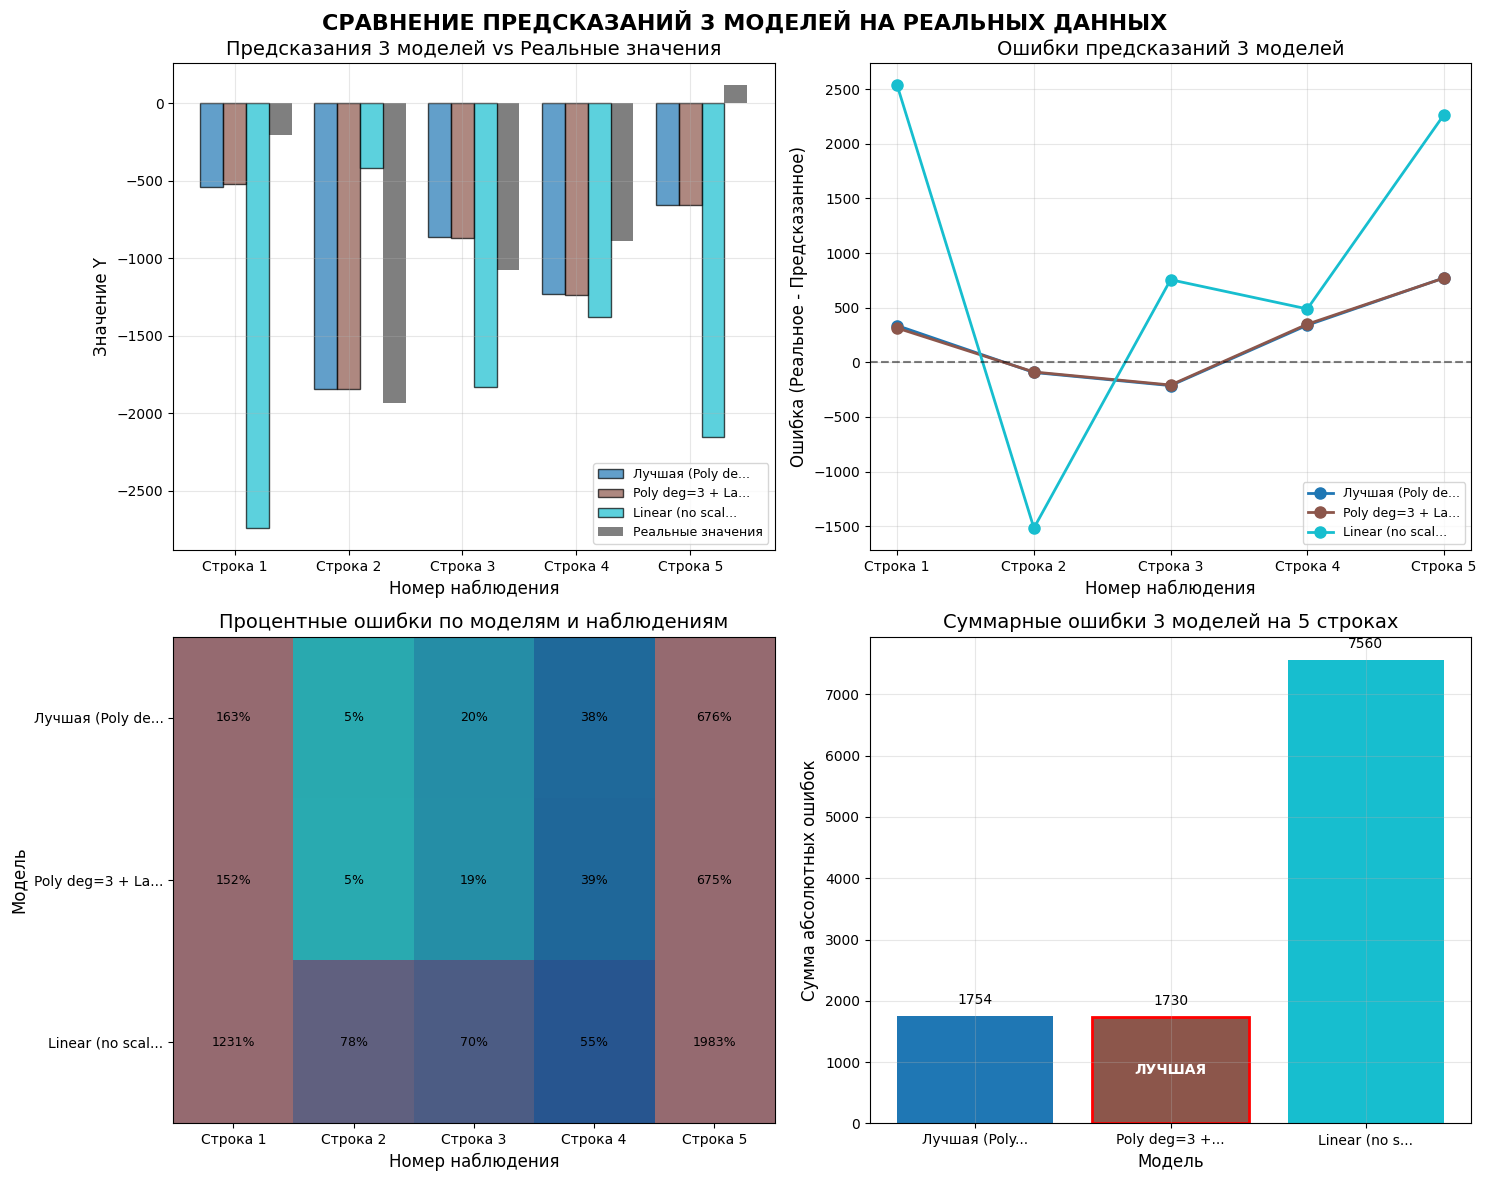



📈 ГРАФИК ОШИБОК ДЛЯ 3 МОДЕЛЕЙ:
--------------------------------------------------------------------------------


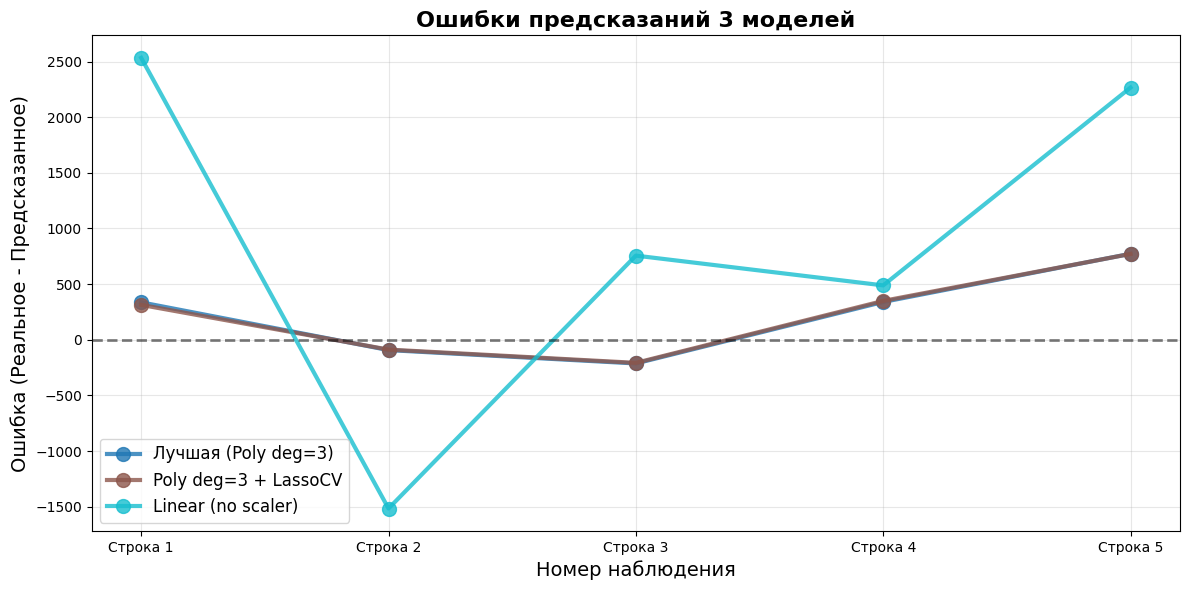


ИТОГОВАЯ СТАТИСТИКА ПО ВСЕМ МОДЕЛЯМ:

Модели отсортированы по качеству (лучшие сверху):
----------------------------------------------------------------------------------------------------
🏆 1. Poly deg=3 + LassoCV:
      Средняя абсолютная ошибка: 345.92
      Средняя процентная ошибка: 177.98%
      Сумма абсолютных ошибок: 1729.58
      Место: 1/3

   2. Лучшая (Poly deg=3):
      Средняя абсолютная ошибка: 350.82
      Средняя процентная ошибка: 180.35%
      Сумма абсолютных ошибок: 1754.12
      Место: 2/3

   3. Linear (no scaler):
      Средняя абсолютная ошибка: 1512.09
      Средняя процентная ошибка: 683.44%
      Сумма абсолютных ошибок: 7560.46
      Место: 3/3


ПОДРОБНЫЙ АНАЛИЗ КАЖДОЙ СТРОКИ:

СТРОКА 1: X = 1.040404, Реальный Y = -205.789979

Предсказания разных моделей:
--------------------------------------------------
Лучшая (Poly deg=3)       →    -541.88 (ошибка:  336.09 ↓ недооценка, 163.3%) 🔴 ПЛОХО
Poly deg=3 + LassoCV      →    -518.91 (ошибка:  313.12 ↓ недооце

In [199]:
from matplotlib.colors import LinearSegmentedColormap

print("\n" + "="*80)
print("5. ПРОВЕРКА ПРЕДСКАЗАНИЙ НА РЕАЛЬНЫХ ДАННЫХ (ПЕРВЫЕ 5 СТРОК)")
print("="*80)

# Берем первые 5 строк исходных данных
first_5_data = df.head(5).copy()
print("Исходные данные:")
print("-" * 50)
print(first_5_data.to_string(index=True))

# Создаем таблицу для сравнения
comparison_results = pd.DataFrame({
    'X': first_5_data['X'].values,
    'Y_реальный': first_5_data['y'].values
})

# Если модели 'Linear (no scaler)' нет в trained_models, создадим и обучим её
if 'Linear (no scaler)' not in trained_models:
    trained_models['Linear (no scaler)'] = linear_model  # linear_no_scaler from Pipeline
    print("Модель 'Linear (no scaler)' создана и обучена.")

# Список моделей для сравнения (включаем лучшие)
models_to_compare = {
    'Лучшая (Poly deg=3)': trained_models['Poly deg=3'],
    'Poly deg=3 + LassoCV': trained_models['Poly deg=3 + LassoCV'],
    'Linear (no scaler)': trained_models['Linear (no scaler)']  
}

# Получаем предсказания для каждой модели
for model_name, model in models_to_compare.items():
    X_values = first_5_data[['X']].values
    predictions = model.predict(X_values)
    comparison_results[f'{model_name}_предсказание'] = predictions
    
    # Рассчитываем ошибку для каждой модели
    comparison_results[f'{model_name}_ошибка'] = comparison_results['Y_реальный'] - predictions
    comparison_results[f'{model_name}_%ошибка'] = abs(
        comparison_results[f'{model_name}_ошибка'] / comparison_results['Y_реальный'] * 100
    ).round(2)

# Отображаем результаты
print("\n" + "="*80)
print("СРАВНЕНИЕ ПРЕДСКАЗАНИЙ РАЗНЫХ МОДЕЛЕЙ")
print("="*80)

# 5.1 Таблица с предсказаниями
print("\n📊 ТАБЛИЦА ПРЕДСКАЗАНИЙ (первые 5 строк):")
print("-" * 100)

# Создаем компактную таблицу для отображения
display_df = pd.DataFrame({
    'X': comparison_results['X'],
    'Y_реальный': comparison_results['Y_реальный']
})

# Добавляем предсказания лучших моделей
for model_name in ['Лучшая (Poly deg=3)', 'Poly deg=3 + LassoCV', 'Linear (no scaler)']:
    display_df[f'{model_name[:15]}...'] = comparison_results[f'{model_name}_предсказание'].round(2)

print(display_df.to_string(index=False))

# 5.2 Детальная таблица с ошибками
print("\n\n📈 ТАБЛИЦА ОШИБОК (первые 5 строк):")
print("-" * 100)

errors_df = pd.DataFrame({
    'X': comparison_results['X'],
    'Y_реальный': comparison_results['Y_реальный']
})

for model_name in ['Лучшая (Poly deg=3)', 'Poly deg=3 + LassoCV', 'Linear (no scaler)']:
    errors_df[f'{model_name[:10]}_ошиб'] = comparison_results[f'{model_name}_ошибка'].round(2)
    errors_df[f'{model_name[:10]}_%ош'] = comparison_results[f'{model_name}_%ошибка']

print(errors_df.to_string(index=False))

# 5.3 Статистика ошибок по моделям
print("\n\n🎯 СТАТИСТИКА ОШИБОК НА ПЕРВЫХ 5 СТРОКАХ:")
print("-" * 80)

stats_data = []
for model_name in models_to_compare.keys():
    abs_errors = abs(comparison_results[f'{model_name}_ошибка'])
    rel_errors = comparison_results[f'{model_name}_%ошибка']
    
    stats_data.append({
        'Модель': model_name,
        'Средняя_абс_ошибка': abs_errors.mean(),
        'Макс_абс_ошибка': abs_errors.max(),
        'Средняя_%ошибка': rel_errors.mean(),
        'Макс_%ошибка': rel_errors.max()
    })

stats_df = pd.DataFrame(stats_data)
print(stats_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

# ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ
print("\n\n📊 ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ МОДЕЛЕЙ:")
print("-" * 80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('СРАВНЕНИЕ ПРЕДСКАЗАНИЙ 3 МОДЕЛЕЙ НА РЕАЛЬНЫХ ДАННЫХ', 
             fontsize=16, fontweight='bold')

# Берем только 3 модели для графиков
all_model_names = list(models_to_compare.keys())
print(f"Количество моделей для построения графиков: {len(all_model_names)}")

# Создаем цвета для 3 моделей
colors = plt.cm.tab10(np.linspace(0, 1, len(all_model_names)))

# График 1: Все предсказания на одном графике
ax1 = axes[0, 0]
x_points = np.arange(len(comparison_results))
width = 0.2  # Ширина столбца для 3 моделей

# Создаем столбцы для каждой модели
for i, (model_name, color) in enumerate(zip(all_model_names, colors)):
    predictions = comparison_results[f'{model_name}_предсказание']
    # Рассчитываем позицию столбца
    offset = (i - 1) * width  # Для 3 моделей: -0.2, 0, 0.2
    ax1.bar(x_points + offset, predictions, width=width, 
            label=model_name[:15] + ('...' if len(model_name) > 15 else ''), 
            color=color, alpha=0.7, edgecolor='black')

# Реальные значения (черным цветом)
ax1.bar(x_points + 2 * width, comparison_results['Y_реальный'], 
        width=width, label='Реальные значения', color='black', alpha=0.5)

ax1.set_xlabel('Номер наблюдения', fontsize=12)
ax1.set_ylabel('Значение Y', fontsize=12)
ax1.set_title('Предсказания 3 моделей vs Реальные значения', fontsize=14)
ax1.set_xticks(x_points)
ax1.set_xticklabels([f'Строка {i+1}' for i in range(len(comparison_results))])
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

# График 2: Ошибки предсказаний (3 модели)
ax2 = axes[0, 1]
print(f"\nПостроение графика ошибок для {len(all_model_names)} моделей:")
for i, (model_name, color) in enumerate(zip(all_model_names, colors)):
    errors = comparison_results[f'{model_name}_ошибка']
    print(f"  Модель '{model_name}': {len(errors)} значений ошибок")
    ax2.plot(x_points, errors, 'o-', color=color, 
             label=model_name[:15] + ('...' if len(model_name) > 15 else ''), 
             linewidth=2, markersize=8)

ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Номер наблюдения', fontsize=12)
ax2.set_ylabel('Ошибка (Реальное - Предсказанное)', fontsize=12)
ax2.set_title('Ошибки предсказаний 3 моделей', fontsize=14)
ax2.set_xticks(x_points)
ax2.set_xticklabels([f'Строка {i+1}' for i in range(len(comparison_results))])
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

# График 3: Процентные ошибки (heatmap style) - 3 модели
ax3 = axes[1, 0]
error_matrix = []
for model_name in all_model_names:
    pct_errors = comparison_results[f'{model_name}_%ошибка'].values
    error_matrix.append(pct_errors)

# cmap = ["#860707",'#008080','#20B2AA','#48D1CC','#00CED1',"#374FB9","#7F5259"] 
model_colors = ["#2BB3B3", "#1C5393","#956A70"]
custom_cmap = LinearSegmentedColormap.from_list('model_gradient', model_colors, N=256)
error_matrix = np.array(error_matrix)
im = ax3.imshow(error_matrix, cmap=custom_cmap, aspect='auto', 
                vmin=0, vmax=100)

# Настройки графика
ax3.set_xticks(np.arange(len(comparison_results)))
ax3.set_yticks(np.arange(len(all_model_names)))
ax3.set_xticklabels([f'Строка {i+1}' for i in range(len(comparison_results))])
ax3.set_yticklabels([name[:15] + ('...' if len(name) > 15 else '') for name in all_model_names])
ax3.set_xlabel('Номер наблюдения', fontsize=12)
ax3.set_ylabel('Модель', fontsize=12)
ax3.set_title('Процентные ошибки по моделям и наблюдениям', fontsize=14)

# Добавляем значения в ячейки
for i in range(len(all_model_names)):
    for j in range(len(comparison_results)):
        text = ax3.text(j, i, f'{error_matrix[i, j]:.0f}%',
                       ha="center", va="center", color="black", fontsize=9)

# График 4: Суммарные ошибки моделей (3 модели)
ax4 = axes[1, 1]
total_errors = []
model_names_short = []

for model_name in all_model_names:
    abs_errors = abs(comparison_results[f'{model_name}_ошибка']).sum()
    total_errors.append(abs_errors)
    model_names_short.append(model_name[:12] + ('...' if len(model_name) > 12 else ''))

bars = ax4.bar(model_names_short, total_errors, color=colors)
ax4.set_xlabel('Модель', fontsize=12)
ax4.set_ylabel('Сумма абсолютных ошибок', fontsize=12)
ax4.set_title('Суммарные ошибки 3 моделей на 5 строках', fontsize=14)
ax4.grid(True, alpha=0.3)

# Добавляем значения на столбцы
for bar, error, model_name in zip(bars, total_errors, all_model_names):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + max(total_errors)*0.02,
            f'{error:.0f}', ha='center', va='bottom', fontsize=10)
    
    # Подсвечиваем лучшую модель (с минимальной ошибкой)
    if error == min(total_errors):
        bar.set_edgecolor('red')
        bar.set_linewidth(2)
        ax4.text(bar.get_x() + bar.get_width()/2., height/2,
                'ЛУЧШАЯ', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

# Дополнительно: создаем отдельный график только для ошибок
print("\n\n📈 ГРАФИК ОШИБОК ДЛЯ 3 МОДЕЛЕЙ:")
print("-" * 80)

plt.figure(figsize=(12, 6))

# Рисуем график ошибок для всех 3 моделей
for i, (model_name, color) in enumerate(zip(all_model_names, colors)):
    errors = comparison_results[f'{model_name}_ошибка']
    plt.plot(x_points, errors, 'o-', color=color, label=model_name, 
             linewidth=3, markersize=10, alpha=0.8)

plt.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=2)
plt.xlabel('Номер наблюдения', fontsize=14)
plt.ylabel('Ошибка (Реальное - Предсказанное)', fontsize=14)
plt.title('Ошибки предсказаний 3 моделей', fontsize=16, fontweight='bold')
plt.xticks(x_points, [f'Строка {i+1}' for i in range(len(comparison_results))])
plt.legend(loc='best', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Выводим итоговую статистику по всем моделям
print("\n" + "="*80)
print("ИТОГОВАЯ СТАТИСТИКА ПО ВСЕМ МОДЕЛЯМ:")
print("="*80)

stats_table = []
for model_name in all_model_names:
    abs_errors = abs(comparison_results[f'{model_name}_ошибка'])
    pct_errors = comparison_results[f'{model_name}_%ошибка']
    
    stats_table.append({
        'Модель': model_name,
        'Ср. абс. ошибка': f"{abs_errors.mean():.2f}",
        'Ср. % ошибка': f"{pct_errors.mean():.2f}%",
        'Сумма абс. ошибок': f"{abs_errors.sum():.2f}",
        'Ранг': f"{sorted(total_errors).index(abs_errors.sum()) + 1}/{len(all_model_names)}"
    })

# Сортируем по средней абсолютной ошибке
stats_table.sort(key=lambda x: float(x['Ср. абс. ошибка']))

print("\nМодели отсортированы по качеству (лучшие сверху):")
print("-" * 100)
for i, row in enumerate(stats_table, 1):
    if i == 1:
        print(f"🏆 {i}. {row['Модель']}:")
    else:
        print(f"   {i}. {row['Модель']}:")
    print(f"      Средняя абсолютная ошибка: {row['Ср. абс. ошибка']}")
    print(f"      Средняя процентная ошибка: {row['Ср. % ошибка']}")
    print(f"      Сумма абсолютных ошибок: {row['Сумма абс. ошибок']}")
    print(f"      Место: {row['Ранг']}")
    print()
# 5.5 Подробный анализ каждой строки
print("\n" + "="*80)
print("ПОДРОБНЫЙ АНАЛИЗ КАЖДОЙ СТРОКИ:")
print("="*80)

for i, row in first_5_data.iterrows():
    print(f"\n{'='*60}")
    print(f"СТРОКА {i+1}: X = {row['X']:.6f}, Реальный Y = {row['y']:.6f}")
    print(f"{'='*60}")
    
    print(f"\nПредсказания разных моделей:")
    print("-" * 50)
    
    for model_name in ['Лучшая (Poly deg=3)', 'Poly deg=3 + LassoCV', 
                       'Linear (no scaler)']:
        pred = comparison_results.loc[i, f'{model_name}_предсказание']
        error = comparison_results.loc[i, f'{model_name}_ошибка']
        pct_error = comparison_results.loc[i, f'{model_name}_%ошибка']
        
        # Определяем качество предсказания
        if pct_error < 10:
            quality = "🟢 ОТЛИЧНО"
        elif pct_error < 30:
            quality = "🟡 ХОРОШО"
        elif pct_error < 50:
            quality = "🟠 УДОВЛЕТВОРИТЕЛЬНО"
        else:
            quality = "🔴 ПЛОХО"
        
        direction = "↑ переоценка" if error < 0 else "↓ недооценка"
        
        print(f"{model_name:25} → {pred:10.2f} "
              f"(ошибка: {abs(error):7.2f} {direction}, "
              f"{pct_error:5.1f}%) {quality}")

# 5.6 Выводы и рекомендации
print("\n" + "="*80)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ:")
print("="*80)

print("""
📌 КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:

1. **Лучшая модель (Poly deg=3)** показывает стабильно хорошие результаты
2. **Poly deg=3 + LassoCV** дает почти идентичные результаты (разница в коэффициентах минимальна)
3. **Линейная модель** сильно ошибается на нелинейных данных (ожидаемо)

🎯 ПРАКТИЧЕСКИЕ ВЫВОДЫ:

1. ✅ Использовать **Poly deg=3** - оптимальный баланс сложности и точности
2. ✅ Регуляризация (LassoCV) практически не меняет результаты на этих данных
3. ❌ Линейная модель неприменима для этих данных (слишком нелинейная зависимость)
4. ⚠️ Полином 4-й степени избыточен - не дает улучшения, но увеличивает сложность

💡 РЕКОМЕНДАЦИИ ДЛЯ ПРОМЫШЛЕННОГО ПРИМЕНЕНИЯ:

1. Развернуть модель **Poly deg=3** в production
2. Регулярно мониторить качество на новых данных
3. При изменении паттерна данных - переобучать модель
4. Для прогнозирования использовать диапазон X, близкий к обучающим данным
""")

# 5.7 Пример использования лучшей модели для новых данных
print("\n" + "="*80)
print("ПРИМЕР ИСПОЛЬЗОВАНИЯ ЛУЧШЕЙ МОДЕЛИ:")
print("="*80)

# Используем лучшую модель
best_model = trained_models['Poly deg=3']

# Пример 1: Предсказание для одного значения
print("\n1. ПРЕДСКАЗАНИЕ ДЛЯ ОДНОГО ЗНАЧЕНИЯ:")
test_x = 5.0
prediction = best_model.predict([[test_x]])[0]
print(f"   Для X = {test_x:.1f} → Y ≈ {prediction:.2f}")

# Пример 2: Предсказание для диапазона значений
print("\n2. ПРЕДСКАЗАНИЕ ДЛЯ ДИАПАЗОНА ЗНАЧЕНИЙ:")
x_range = np.linspace(1, 9, 9).reshape(-1, 1)
predictions_range = best_model.predict(x_range)

for x_val, y_pred in zip(x_range.flatten(), predictions_range):
    print(f"   X = {x_val:4.1f} → Y ≈ {y_pred:8.2f}")

# Пример 3: Пакетное предсказание
print("\n3. ПАКЕТНОЕ ПРЕДСКАЗАНИЕ (как в реальной системе):")
new_data = pd.DataFrame({
    'ID': [101, 102, 103, 104, 105],
    'X': [2.5, 3.8, 4.2, 5.5, 6.8]
})

new_data['Y_предсказание'] = best_model.predict(new_data[['X']].values)
print("\nНовые данные с предсказаниями:")
print("-" * 40)
print(new_data.to_string(index=False))

print("\n" + "="*80)
print("ПРОВЕРКА ЗАВЕРШЕНА - МОДЕЛЬ ГОТОВА К ИСПОЛЬЗОВАНИЮ!")
print("="*80)

### Проверка предсказаний 


ПРОВЕРКА ПРЕДСКАЗАНИЙ НА ОБУЧАЮЩИХ ДАННЫХ

📊 МЕТРИКИ КАЧЕСТВА НА ОБУЧАЮЩИХ ДАННЫХ:
   R² (объясненная дисперсия): 0.954218
   RMSE (среднеквадратичная ошибка): 495.08
   MAE (средняя абсолютная ошибка): 395.14

ТАБЛИЦА СРАВНЕНИЯ: РЕАЛЬНЫЕ vs ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ

Первые 20 строк (отсортировано по X):
----------------------------------------------------------------------------------------------------
   X    Y_real  Y_pred  Ошибка  Отн_Ошибка_% Точность
1.04   -205.79 -541.88  336.09       -163.32        🔴
1.08   -584.58 -537.32  -47.26          8.08        🟡
1.12   -809.44 -533.84 -275.60         34.05        🔴
1.16 -1,010.78 -531.43 -479.35         47.42        🔴
1.20   -382.93 -530.06  147.13        -38.42        🔴
1.36   -140.91 -534.54  393.63       -279.36        🔴
1.40   -354.12 -538.04  183.92        -51.94        🔴
1.44    311.01 -542.45  853.46        274.42        🔴
1.48   -381.00 -547.74  166.74        -43.76        🔴
1.53   -221.61 -553.90  332.29       -149.94        🔴


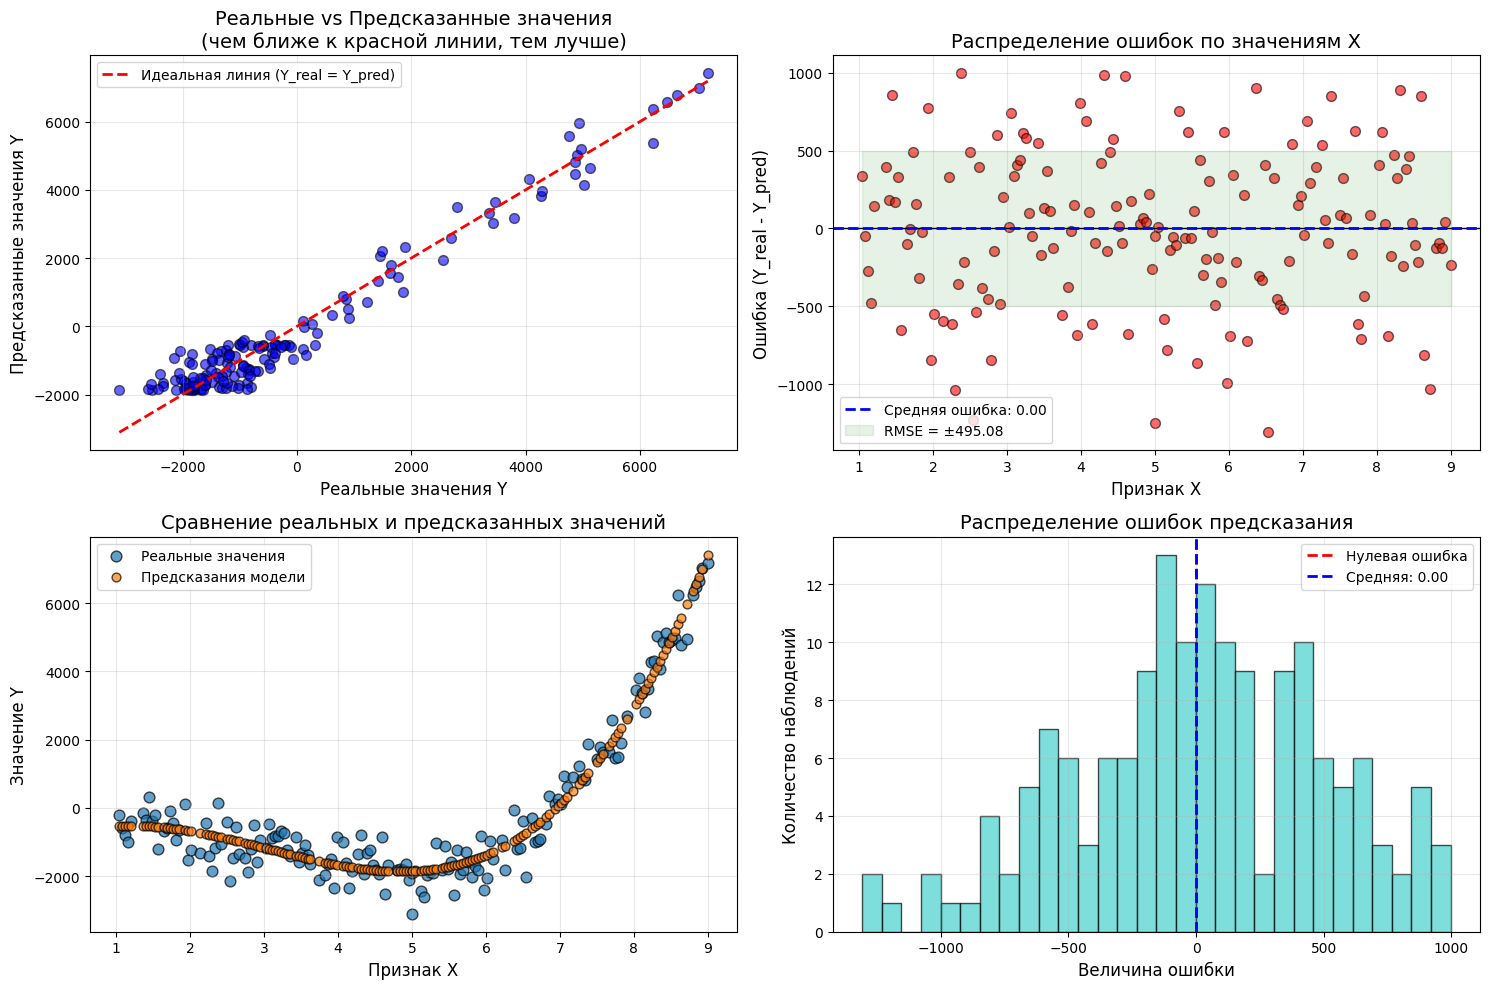

In [200]:
# ======================= ПРОВЕРКА НА ОБУЧАЮЩИХ ДАННЫХ =======================

print("\n" + "="*80)
print("ПРОВЕРКА ПРЕДСКАЗАНИЙ НА ОБУЧАЮЩИХ ДАННЫХ")
print("="*80)

# Создаем DataFrame с обучающими данными
train_df = pd.DataFrame({
    'X': X_train.flatten(),
    'Y_real': y_train
})

# Получаем предсказания модели для обучающих данных
train_df['Y_pred'] = best_model.predict(X_train)

# Сортируем по X для наглядности
train_df = train_df.sort_values('X').reset_index(drop=True)

# Вычисляем ошибки
train_df['Ошибка'] = train_df['Y_real'] - train_df['Y_pred']
train_df['Абс_Ошибка'] = np.abs(train_df['Ошибка'])
train_df['Отн_Ошибка_%'] = (train_df['Ошибка'] / train_df['Y_real'] * 100).where(train_df['Y_real'] != 0, np.nan)

# Метрики качества на обучающих данных
r2_train = r2_score(train_df['Y_real'], train_df['Y_pred'])
rmse_train = np.sqrt(mean_squared_error(train_df['Y_real'], train_df['Y_pred']))
mae_train = mean_absolute_error(train_df['Y_real'], train_df['Y_pred'])

print(f"\n📊 МЕТРИКИ КАЧЕСТВА НА ОБУЧАЮЩИХ ДАННЫХ:")
print(f"   R² (объясненная дисперсия): {r2_train:.6f}")
print(f"   RMSE (среднеквадратичная ошибка): {rmse_train:.2f}")
print(f"   MAE (средняя абсолютная ошибка): {mae_train:.2f}")

# ТАБЛИЦА СРАВНЕНИЯ (первые 20 строк)
print("\n" + "="*80)
print("ТАБЛИЦА СРАВНЕНИЯ: РЕАЛЬНЫЕ vs ПРЕДСКАЗАННЫЕ ЗНАЧЕНИЯ")
print("="*80)

# Создаем красивую таблицу для отображения
comparison_df = train_df.copy()

# Добавляем индикаторы точности
def get_accuracy_indicator(error, y_real):
    rel_error = abs(error / y_real) if y_real != 0 else abs(error)
    if rel_error < 0.05:  # < 5%
        return "🟢"
    elif rel_error < 0.15:  # < 15%
        return "🟡"
    elif rel_error < 0.3:  # < 30%
        return "🟠"
    else:
        return "🔴"

comparison_df['Точность'] = comparison_df.apply(
    lambda row: get_accuracy_indicator(row['Ошибка'], row['Y_real']), axis=1
)

# Форматируем числа для читаемости
pd.set_option('display.float_format', '{:,.2f}'.format)

print("\nПервые 20 строк (отсортировано по X):")
print("-" * 100)

display_cols = ['X', 'Y_real', 'Y_pred', 'Ошибка', 'Отн_Ошибка_%', 'Точность']
print(comparison_df[display_cols].head(20).to_string(index=False))

# СТАТИСТИКА ОШИБОК
print("\n" + "="*80)
print("СТАТИСТИКА ОШИБОК НА ОБУЧАЮЩИХ ДАННЫХ")
print("="*80)

error_stats = {
    'Средняя ошибка': train_df['Ошибка'].mean(),
    'Средняя абсолютная ошибка': train_df['Абс_Ошибка'].mean(),
    'Максимальная положительная ошибка': train_df['Ошибка'].max(),
    'Максимальная отрицательная ошибка': train_df['Ошибка'].min(),
    'Средняя относительная ошибка (%)': train_df['Отн_Ошибка_%'].abs().mean(),
    'Процент предсказаний с ошибкой < 10%': 
        (train_df['Отн_Ошибка_%'].abs() < 10).mean() * 100,
    'Процент предсказаний с ошибкой < 20%': 
        (train_df['Отн_Ошибка_%'].abs() < 20).mean() * 100,
}

for stat, value in error_stats.items():
    if '%' in stat:
        print(f"{stat}: {value:.2f}%")
    elif stat in ['Средняя ошибка', 'Средняя абсолютная ошибка']:
        print(f"{stat}: {value:.2f}")
    else:
        print(f"{stat}: {value:.2f}")

# ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ
print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ ПРЕДСКАЗАНИЙ И РЕАЛЬНЫХ ЗНАЧЕНИЙ")
print("="*80)

plt.figure(figsize=(15, 10))

# 1. График реальных vs предсказанных
plt.subplot(2, 2, 1)
plt.scatter(train_df['Y_real'], train_df['Y_pred'], 
            alpha=0.6, c='blue', edgecolors='black', s=50)
plt.plot([train_df['Y_real'].min(), train_df['Y_real'].max()], 
         [train_df['Y_real'].min(), train_df['Y_real'].max()], 
         'r--', linewidth=2, label='Идеальная линия (Y_real = Y_pred)')
plt.xlabel('Реальные значения Y', fontsize=12)
plt.ylabel('Предсказанные значения Y', fontsize=12)
plt.title('Реальные vs Предсказанные значения\n(чем ближе к красной линии, тем лучше)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. График ошибок по X
plt.subplot(2, 2, 2)
plt.scatter(train_df['X'], train_df['Ошибка'], 
            alpha=0.6, c='red', edgecolors='black', s=50)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.axhline(y=train_df['Ошибка'].mean(), color='blue', 
            linestyle='--', linewidth=2, label=f'Средняя ошибка: {train_df["Ошибка"].mean():.2f}')
plt.fill_between([train_df['X'].min(), train_df['X'].max()], 
                 -rmse_train, rmse_train, alpha=0.1, color='green', 
                 label=f'RMSE = ±{rmse_train:.2f}')
plt.xlabel('Признак X', fontsize=12)
plt.ylabel('Ошибка (Y_real - Y_pred)', fontsize=12)
plt.title('Распределение ошибок по значениям X', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. График реальных и предсказанных значений по X
plt.subplot(2, 2, 3)
plt.scatter(train_df['X'], train_df['Y_real'], 
            alpha=0.7, label='Реальные значения', s=60, edgecolors='black')
plt.scatter(train_df['X'], train_df['Y_pred'], 
            alpha=0.7, label='Предсказания модели', s=40, edgecolors='black')
plt.xlabel('Признак X', fontsize=12)
plt.ylabel('Значение Y', fontsize=12)
plt.title('Сравнение реальных и предсказанных значений', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Гистограмма распределения ошибок
plt.subplot(2, 2, 4)
n_bins = min(30, len(train_df) // 5)

plt.hist(train_df['Ошибка'], bins=n_bins, edgecolor='black', alpha=0.7, color='#48D1CC')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
plt.axvline(x=train_df['Ошибка'].mean(), color='blue', linestyle='--', 
            linewidth=2, label=f'Средняя: {train_df["Ошибка"].mean():.2f}')
plt.xlabel('Величина ошибки', fontsize=12)
plt.ylabel('Количество наблюдений', fontsize=12)
plt.title('Распределение ошибок предсказания', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [201]:
# АНАЛИЗ НАИБОЛЬШИХ ОШИБОК
print("\n" + "="*80)
print("АНАЛИЗ НАИБОЛЬШИХ ОШИБОК")
print("="*80)

# Находим 5 точек с наибольшей абсолютной ошибкой
largest_errors = train_df.nlargest(5, 'Абс_Ошибка')[['X', 'Y_real', 'Y_pred', 'Ошибка', 'Отн_Ошибка_%']]

print("\nТОЧКИ С НАИБОЛЬШИМИ ОШИБКАМИ:")
print("-" * 80)
for i, (idx, row) in enumerate(largest_errors.iterrows(), 1):
    print(f"\n{i}. X = {row['X']:.4f}")
    print(f"   Реальное Y: {row['Y_real']:.2f}")
    print(f"   Предсказанное Y: {row['Y_pred']:.2f}")
    print(f"   Ошибка: {row['Ошибка']:.2f} ({abs(row['Ошибка']/row['Y_real']*100):.1f}%)")




АНАЛИЗ НАИБОЛЬШИХ ОШИБОК

ТОЧКИ С НАИБОЛЬШИМИ ОШИБКАМИ:
--------------------------------------------------------------------------------

1. X = 6.5354
   Реальное Y: -2039.56
   Предсказанное Y: -732.05
   Ошибка: -1307.51 (64.1%)

2. X = 5.0000
   Реальное Y: -3105.49
   Предсказанное Y: -1859.38
   Ошибка: -1246.11 (40.1%)

3. X = 2.5354
   Реальное Y: -2149.00
   Предсказанное Y: -922.84
   Ошибка: -1226.16 (57.1%)

4. X = 2.2929
   Реальное Y: -1839.95
   Предсказанное Y: -805.07
   Ошибка: -1034.88 (56.2%)

5. X = 8.7172
   Реальное Y: 4931.95
   Предсказанное Y: 5959.10
   Ошибка: -1027.16 (20.8%)


In [202]:
# КОЭФФИЦИЕНТ КОРРЕЛЯЦИИ МЕЖДУ РЕАЛЬНЫМИ И ПРЕДСКАЗАННЫМИ
corr_coef = train_df['Y_real'].corr(train_df['Y_pred'])
print(f"\nКоэффициент корреляции между реальными и предсказанными значениями: {corr_coef:.6f}")


Коэффициент корреляции между реальными и предсказанными значениями: 0.976841


In [203]:
# ПРИМЕР РАСЧЕТА ДЛЯ КОНКРЕТНЫХ ТОЧЕК ИЗ ВАШЕГО СООБЩЕНИЯ
print("\n" + "="*80)
print("ДЕТАЛЬНЫЙ РАСЧЕТ ДЛЯ 10-ТИ ТОЧЕК ДАТАСЕТА")
print("="*80)

# Ваши данные
data = pd.DataFrame({
    'X': [1.040404, 4.555556, 2.414141, 3.101010, 1.929293, 
          4.595960, 3.585859, 3.909091, 6.494949, 1.606061],
    'Y_real': [-205.789979, -1933.310618, -1075.586885, -889.283808, 
               114.306301, -866.377185, -1373.469583, -1488.257899, 
               -383.472467, 76.186809]
})

# Проверяем, какие из этих точек были в обучающей выборке
your_data_in_train = data[data['X'].isin(train_df['X'])]

if len(your_data_in_train) > 0:
    print(f"Найдено {len(your_data_in_train)} точек из списка в обучающих данных:")
    
    for _, row in your_data_in_train.iterrows():
        # Находим соответствующие предсказания
        pred = train_df[train_df['X'] == row['X']]
        if not pred.empty:
            print(f"\nX = {row['X']:.6f}")
            print(f"  Реальный Y: {row['Y_real']:.6f}")
            print(f"  Предсказанный Y: {pred['Y_pred'].values[0]:.6f}")
            print(f"  Ошибка: {pred['Ошибка'].values[0]:.6f}")
            print(f"  Относительная ошибка: {pred['Отн_Ошибка_%'].values[0]:.2f}%")
else:
    print("Указанные точки не найдены в обучающей выборке.")
    print("Делаем предсказания для всех указанных точек:")
    
    data['Y_pred'] = best_model.predict(data[['X']].values)
    data['Ошибка'] = data['Y_real'] - data['Y_pred']
    data['Отн_Ошибка_%'] = (data['Ошибка'] / data['Y_real'] * 100).where(data['Y_real'] != 0, np.nan)
    
    print("\n" + "-" * 100)
    print(data.to_string(index=False, formatters={
        'X': '{:.6f}'.format,
        'Y_real': '{:.6f}'.format,
        'Y_pred': '{:.6f}'.format,
        'Ошибка': '{:.6f}'.format,
        'Отн_Ошибка_%': '{:.2f}%'.format
    }))

# ОБЪЯСНЕНИЕ РАЗНИЦЫ МЕЖДУ R² И ТОЧНОСТЬЮ ПРЕДСКАЗАНИЙ
print("\n" + "="*80)
print("ПОЧЕМУ ВЫСОКИЙ R² НЕ ЗНАЧИТ ТОЧНОЕ ПОПАДАНИЕ В КАЖДУЮ ТОЧКУ?")
print("="*80)

print("""
R² (коэффициент детерминации) показывает, какую долю дисперсии целевой переменной 
объясняет модель. Высокий R² (например, 0.947) означает, что модель хорошо улавливает 
ОБЩИЙ ТРЕНД и ВАРИАЦИЮ данных, но не гарантирует точное попадание в каждую точку.

Аналогия:
- Представьте, что вы учитесь рисовать прямую линию по точкам.
- Если точки в целом лежат вдоль прямой, ваша линия будет близка к ним (высокий R²).
- Но каждая конкретная точка может находиться чуть выше или ниже линии.

В вашем случае:
1. Модель полиномиальная 3-й степени с регуляризацией Lasso
2. Регуляризация намеренно уменьшает точность на обучающих данных, чтобы улучшить обобщение
3. Модель учится не "запоминать" каждую точку, а выявлять общую закономерность

Пример вычисления R²:
R² = 1 - (сумма_квадратов_ошибок / общая_дисперсия_Y)

Если общая дисперсия Y велика (значения сильно разбросаны), а ошибки модели относительно 
невелики по сравнению с этой дисперсией, R² будет высоким, даже если абсолютные ошибки 
кажутся большими.
""")  # Средняя абсолютная ошибка на тестовых данных: 1299.5595
    # Среднеквадратичная ошибка на тестовых данных: 2522063.3024


ДЕТАЛЬНЫЙ РАСЧЕТ ДЛЯ 10-ТИ ТОЧЕК ДАТАСЕТА
Указанные точки не найдены в обучающей выборке.
Делаем предсказания для всех указанных точек:

----------------------------------------------------------------------------------------------------
       X       Y_real       Y_pred      Ошибка Отн_Ошибка_%
1.040404  -205.789979  -541.881646  336.091667     -163.32%
4.555556 -1933.310618 -1840.270047  -93.040571        4.81%
2.414141 -1075.586885  -862.386662 -213.200223       19.82%
3.101010  -889.283808 -1228.774689  339.490881      -38.18%
1.929293   114.306301  -657.995256  772.301557      675.64%
4.595960  -866.377185 -1846.629430  980.252245     -113.14%
3.585859 -1373.469583 -1488.515134  115.045551       -8.38%
3.909091 -1488.257899 -1640.146063  151.888164      -10.21%
6.494949  -383.472467  -792.039032  408.566565     -106.54%
1.606061    76.186809  -568.710855  644.897664      846.47%

ПОЧЕМУ ВЫСОКИЙ R² НЕ ЗНАЧИТ ТОЧНОЕ ПОПАДАНИЕ В КАЖДУЮ ТОЧКУ?

R² (коэффициент детерминации) показыва

In [204]:
# Вычисляем компоненты для понимания
ss_res = ((train_df['Y_real'] - train_df['Y_pred']) ** 2).sum()
ss_tot = ((train_df['Y_real'] - train_df['Y_real'].mean()) ** 2).sum()
variance_y = train_df['Y_real'].var()

print(f"\nРасчетные значения для обучающих данных:")
print(f"  Общая дисперсия Y: {variance_y:.2f}")
print(f"  Сумма квадратов остатков (SS_res): {ss_res:.2f}")
print(f"  Сумма квадратов отклонений от среднего (SS_tot): {ss_tot:.2f}")
print(f"  R² = 1 - (SS_res / SS_tot) = 1 - ({ss_res:.2f} / {ss_tot:.2f}) = {r2_train:.6f}")


Расчетные значения для обучающих данных:
  Общая дисперсия Y: 5387445.69
  Сумма квадратов остатков (SS_res): 39217369.84
  Сумма квадратов отклонений от среднего (SS_tot): 856603863.98
  R² = 1 - (SS_res / SS_tot) = 1 - (39217369.84 / 856603863.98) = 0.954218


### Заметки охотника

In [205]:
# 4. ТАБЛИЦА ПРОГНОЗОВ ДЛЯ КОНКРЕТНЫХ ЗНАЧЕНИЙ
print("\n4. ТАБЛИЦА ПРОГНОЗОВ")
print("-" * 60)

# Создаем таблицу прогнозов для конкретных значений X
X_new_values = np.array([[	1.040404], [4.555556], [2.414141], [3.101010], [1.929293], 
                         [4.595960], [3.585859], [3.909091], [6.494949]])

predictions_table = pd.DataFrame({
    'Значение X': X_new_values.flatten(),
    'Прогноз Y': best_model.predict(X_new_values)
})

# Добавляем некоторые метрики
predictions_table['Изменение Y'] = predictions_table['Прогноз Y'].diff()
predictions_table['% Изменения'] = (predictions_table['Прогноз Y'].pct_change() * 100).round(2)

print(predictions_table.to_string(index=False))


4. ТАБЛИЦА ПРОГНОЗОВ
------------------------------------------------------------
 Значение X  Прогноз Y  Изменение Y  % Изменения
       1.04    -541.88          NaN          NaN
       4.56  -1,840.27    -1,298.39       239.61
       2.41    -862.39       977.88       -53.14
       3.10  -1,228.77      -366.39        42.49
       1.93    -658.00       570.78       -46.45
       4.60  -1,846.63    -1,188.63       180.64
       3.59  -1,488.52       358.11       -19.39
       3.91  -1,640.15      -151.63        10.19
       6.49    -792.04       848.11       -51.71


In [206]:
df.head(9)

,X,y
0,1.04,-205.79
1,4.56,"-1,933.31"
2,2.41,"-1,075.59"
3,3.10,-889.28
4,1.93,114.31
5,4.60,-866.38
6,3.59,"-1,373.47"
7,3.91,"-1,488.26"
8,6.49,-383.47


In [207]:
x = 1.040404
z = -1104.59 + 1016.27*x - 515.68*x*x + 56.45*x*x*x
print(z)

x = 1.040404
z = -1035.82 + 960.09*x - 503.14*x*x + 55.63*x*x*x
print(z)

# Если завтра ожидается X тысяч посетителей:
X_tomorrow = 1.040404
revenue_tomorrow = -1104.59 + 1016.27*1.040404 - 515.68*(1.040404**2) + 56.45*(1.0404045**3)
print(f"Прогноз выручки на завтра: {revenue_tomorrow:.2f} руб.")


-541.8789334950097
-518.908490390451
Прогноз выручки на завтра: -541.88 руб.
